In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

sns.set()

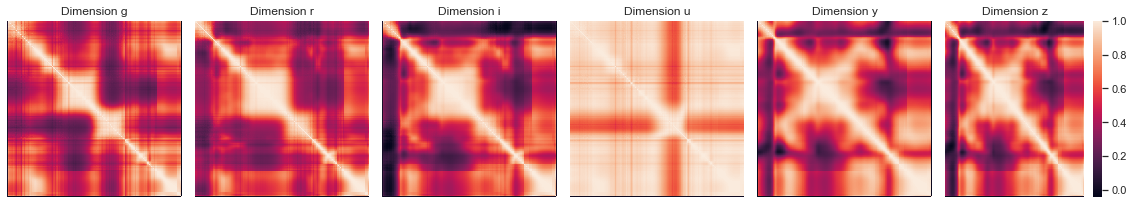

In [2]:
plt.figure(figsize=(16, 3))
for i, b in enumerate('griuyz'):
    ax = plt.subplot(1, 6, i+1)
    sns.heatmap(pd.read_csv(f'../../UST-Python/dataset/plasticc_5d_dataset/plassticc_5d_{b}/plassticc_5d_{b}_TRAIN.csv').corr(), ax=ax, cbar=(i == 5))
    ax.set_title('Dimension '+ b)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
        
plt.tight_layout()
plt.show()
#plt.savefig('../images/plasticc_heatmap')

# Rocket results

Let's start by loading the result file for rocket. It is a csv file with $7$ columns:

- Model: the classifier used after rocket transform
- Runno: the run number. Each model is run three times, therefore there three run numbers
- Precision: the precision of the classifier
- Recall: the recall of the classifier
- F1score: the harmonic mean of the precision and the recall or F1 score
- LogLoss: the cross entropy loss of the classifier
- Time: the number of seconds took by the model to execute

In [2]:
rocket_results = pd.read_csv('../results/plasticc/rocket_plasticc.csv')
#rocket_results = rocket_results.drop(columns=['Runno']) # we drop this column as it will not be used
rocket_results

,Model,Runno,Precision,Recall,F1score,LogLoss,Time
0,Ridge,0,0.706531,0.703822,0.694311,2.068253,195.305088
1,RF,0,0.761768,0.750318,0.721923,0.937063,195.305088
2,XGBoost,0,0.765822,0.777707,0.760790,0.834781,195.305088
3,Ridge,1,0.714419,0.714013,0.704341,2.065186,194.078902
4,RF,1,0.746529,0.752229,0.724215,0.968382,194.078902
5,XGBoost,1,0.776390,0.776433,0.758218,0.823468,194.078902
6,Ridge,2,0.722978,0.721656,0.711310,2.063170,194.155917
7,RF,2,0.744794,0.752866,0.725138,0.916880,194.155917
8,XGBoost,2,0.778212,0.774522,0.754548,0.810659,194.155917


## Averaging over runs

Here we agregate the performance metrics (Precision, Recall, F1 score, Loss and running time) on every runs by computing the mean and the standard deviation

In [3]:
rocket_result_avg = rocket_results.loc[:, rocket_results.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
rocket_result_avg

Precision              Recall             F1score             LogLoss  \
             mean       std      mean       std      mean       std      mean   
Model                                                                           
RF       0.751030  0.009339  0.751805  0.001326  0.723759  0.001655  0.940775   
Ridge    0.714643  0.008226  0.713163  0.008947  0.703321  0.008546  2.065536   
XGBoost  0.773475  0.006690  0.776221  0.001603  0.757852  0.003137  0.822969   

                         Time            
              std        mean       std  
Model                                    
RF       0.025951  194.513302  0.686787  
Ridge    0.002560  194.513302  0.686787  
XGBoost  0.012069  194.513302  0.686787

## The best run for each classifier

For each model, we keep the one which achieved the lowest cross entropy loss.

In [4]:
def get_best(df, metric='LogLoss'):
    idxmin = df.groupby(['Model'])['LogLoss'].idxmin()
    df_best = df.loc[idxmin]
    return df_best

In [5]:
paper_cols = ['Precision', 'Recall', 'F1score', 'LogLoss', 'Time'] # columns to include for the paper
def format_result_for_paper(df_result, paper_cols=paper_cols):
    df_avg = df_result.loc[:, df_result.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
    df_avg = df_avg[paper_cols]
    df_avg.columns = ['Precision', 'Precision_std', 'Recall', 'Recall_std', 'F1score', 'F1score_std', 'LogLoss', 'LogLoss_std', 'Time', 'Time_std']
    best_model = df_result.iloc[df_result.LogLoss.idxmin()]
    df_avg.loc[best_model.Model+'*'] = best_model[paper_cols]
    return df_avg

In [6]:
rocket_results_best = get_best(rocket_results)
rocket_results_best

,Model,Runno,Precision,Recall,F1score,LogLoss,Time
7,RF,2,0.744794,0.752866,0.725138,0.916880,194.155917
6,Ridge,2,0.722978,0.721656,0.711310,2.063170,194.155917
8,XGBoost,2,0.778212,0.774522,0.754548,0.810659,194.155917


In [7]:
ROCKET = format_result_for_paper(rocket_results)
ROCKET

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.751030,0.009339,0.751805,0.001326,0.723759,0.001655,0.940775,0.025951,194.513302,0.686787
Ridge,0.714643,0.008226,0.713163,0.008947,0.703321,0.008546,2.065536,0.002560,194.513302,0.686787
XGBoost,0.773475,0.006690,0.776221,0.001603,0.757852,0.003137,0.822969,0.012069,194.513302,0.686787
XGBoost*,0.778212,NaN,0.774522,NaN,0.754548,NaN,0.810659,NaN,194.155917,NaN


# USAST results

USAST results have the same columns as Rocket results but include two additional columns:

- NbKernelNoDuplicates: the number of subsequences after duplicates are dropped
- NbKernelDuplicates: the number of subsequences before dropping duplicate subsequences

Therefore $NbKernelDuplicates \ge NbKernelNoDuplicates$

There are three case:

1. cF_dF: in this scenario, there is no duplicates dropping and the number of occurrences is not counted
2. cF_dT: in this scenario, duplicates are dropped but the number of occurrences is not counted
3. cT_dT: in this scenerio, duplicates are dropped and the number of occurrences is counted

## Scenario cF_dF

In [4]:
sast_results_cF_dF = pd.read_csv('../results/plasticc/m16M32ls4/result_plasticc_r0.25_cF_dF.csv')
sast_results_cF_dF.Time /= 3600
sast_results_cF_dF

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
0,Ridge,0,0.554384,0.568790,0.546821,2.211909,16.228749,16660,16660
1,RF,0,0.574479,0.614650,0.557768,1.351790,16.228749,16660,16660
2,XGBoost,0,0.650107,0.672611,0.637041,1.146018,16.228749,16660,16660
3,Ridge,1,0.555521,0.573248,0.552843,2.207656,16.992764,16660,16660
4,RF,1,0.564266,0.606369,0.549815,1.256846,16.992764,16660,16660
5,XGBoost,1,0.657783,0.672611,0.633795,1.164375,16.992764,16660,16660
6,Ridge,2,0.556235,0.574522,0.549592,2.228704,15.998157,16660,16660
7,RF,2,0.638595,0.615287,0.559767,1.263627,15.998157,16660,16660
8,XGBoost,2,0.634302,0.666879,0.629353,1.163213,15.998157,16660,16660


In [5]:
usast_results_cF_dF = pd.read_csv('../results/plasticc/result_plasticc_u_r0.25_cF_dF.csv')
usast_results_cF_dF.Time /= 3600

usast_results_cF_dF2 = pd.read_csv('../results/plasticc/m20M64ls10/result_plasticc_u_r0.25_cF_dF.csv')
usast_results_cF_dF2.Time /= 3600

usast_results_cF_dF

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
0,Ridge,0,0.323240,0.329299,0.320826,3.098230,53.720907,16660,16660
1,RF,0,0.624793,0.657325,0.598938,1.182424,53.720907,16660,16660
2,XGBoost,0,0.688490,0.696178,0.659411,1.040875,53.720907,16660,16660
3,UGNB,0,0.001876,0.043312,0.003596,33.042829,53.720907,16660,16660
4,Ridge,1,0.316982,0.328025,0.316208,2.968989,53.558107,16660,16660
5,RF,1,0.620075,0.665605,0.607549,1.235151,53.558107,16660,16660
6,XGBoost,1,0.688330,0.696815,0.659086,1.039815,53.558107,16660,16660
7,UGNB,1,0.001876,0.043312,0.003596,33.042829,53.558107,16660,16660
8,Ridge,2,0.352725,0.356688,0.349498,2.882846,53.543125,16660,16660
9,RF,2,0.608434,0.650318,0.591834,1.193414,53.543125,16660,16660


UGNB achieves very bad results. This could be due to three facts:

1. There might be an error in the code.⚠️
2. The independence assumption made in Naive Bayes classifier is not met. This is probably the real cause of bad UGNB performance because there are lots of similar subsequences in the dataset. 👍🏾
4. The dataset is highly imbalance. 👍🏾

In [6]:
sast_results_cF_dF_avg = sast_results_cF_dF.loc[:, sast_results_cF_dF.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
sast_results_cF_dF_avg

Precision              Recall             F1score             LogLoss  \
             mean       std      mean       std      mean       std      mean   
Model                                                                           
RF       0.592447  0.040291  0.612102  0.004975  0.555783  0.005265  1.290754   
Ridge    0.555380  0.000933  0.572187  0.003010  0.549752  0.003014  2.216090   
XGBoost  0.647397  0.011973  0.670701  0.003310  0.633396  0.003859  1.157869   

                        Time           NbKernelNoDuplicates       \
              std       mean       std                 mean  std   
Model                                                              
RF       0.052967  16.406557  0.520598              16660.0  0.0   
Ridge    0.011129  16.406557  0.520598              16660.0  0.0   
XGBoost  0.010279  16.406557  0.520598              16660.0  0.0   

        NbKernelDuplicates       
                      mean  std  
Model                            
RF                 16660.0  0.0  
Ridge              16660.0  0.0  
XGBoost            16660.0  0.0

In [7]:
SAST = format_result_for_paper(sast_results_cF_dF)
SAST

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.592447,0.040291,0.612102,0.004975,0.555783,0.005265,1.290754,0.052967,16.406557,0.520598
Ridge,0.555380,0.000933,0.572187,0.003010,0.549752,0.003014,2.216090,0.011129,16.406557,0.520598
XGBoost,0.647397,0.011973,0.670701,0.003310,0.633396,0.003859,1.157869,0.010279,16.406557,0.520598
XGBoost*,0.650107,NaN,0.672611,NaN,0.637041,NaN,1.146018,NaN,16.228749,NaN


In [8]:
usast_results_cF_dF_avg = usast_results_cF_dF.loc[:, usast_results_cF_dF.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
usast_results_cF_dF_avg

Precision              Recall             F1score            \
             mean       std      mean       std      mean       std   
Model                                                                 
RF       0.617767  0.008420  0.657749  0.007652  0.599440  0.007870   
Ridge    0.330983  0.019088  0.338004  0.016193  0.328844  0.018035   
UGNB     0.001876  0.000000  0.043312  0.000000  0.003596  0.000000   
XGBoost  0.687875  0.000930  0.698089  0.002776  0.661541  0.003974   

           LogLoss                Time           NbKernelNoDuplicates       \
              mean       std      mean       std                 mean  std   
Model                                                                        
RF        1.203663  0.027818  53.60738  0.098603              16660.0  0.0   
Ridge     2.983355  0.108409  53.60738  0.098603              16660.0  0.0   
UGNB     33.042829  0.000000  53.60738  0.098603              16660.0  0.0   
XGBoost   1.044417  0.007072  53.60738  0.098603              16660.0  0.0   

        NbKernelDuplicates       
                      mean  std  
Model                            
RF                 16660.0  0.0  
Ridge              16660.0  0.0  
UGNB               16660.0  0.0  
XGBoost            16660.0  0.0

In [9]:
uSAST = format_result_for_paper(usast_results_cF_dF)

uSAST2 = format_result_for_paper(usast_results_cF_dF2)

uSAST

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.617767,0.008420,0.657749,0.007652,0.599440,0.007870,1.203663,0.027818,53.607380,0.098603
Ridge,0.330983,0.019088,0.338004,0.016193,0.328844,0.018035,2.983355,0.108409,53.607380,0.098603
UGNB,0.001876,0.000000,0.043312,0.000000,0.003596,0.000000,33.042829,0.000000,53.607380,0.098603
XGBoost,0.687875,0.000930,0.698089,0.002776,0.661541,0.003974,1.044417,0.007072,53.607380,0.098603
XGBoost*,0.688330,NaN,0.696815,NaN,0.659086,NaN,1.039815,NaN,53.558107,NaN


In [10]:
sast_results_cF_dF_best = get_best(sast_results_cF_dF)
usast_results_cF_dF_best = get_best(usast_results_cF_dF)

usast_results_cF_dF_best

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
1,RF,0,0.624793,0.657325,0.598938,1.182424,53.720907,16660,16660
8,Ridge,2,0.352725,0.356688,0.349498,2.882846,53.543125,16660,16660
3,UGNB,0,0.001876,0.043312,0.003596,33.042829,53.720907,16660,16660
6,XGBoost,1,0.688330,0.696815,0.659086,1.039815,53.558107,16660,16660


## Scenario cF_dT

In [11]:
sast_results_cF_dT = pd.read_csv('../results/plasticc/m16M32ls4/result_plasticc_r0.25_cF_dT.csv')
sast_results_cF_dT.Time /= 3600
sast_results_cF_dT

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
0,Ridge,0,0.551231,0.571338,0.547720,2.203001,11.840898,11418,16660
1,RF,0,0.556842,0.598726,0.539344,1.249367,11.840898,11418,16660
2,XGBoost,0,0.662785,0.675796,0.639266,1.131344,11.840898,11418,16660
3,Ridge,1,0.560484,0.570064,0.550424,2.205203,13.061219,12318,16660
4,RF,1,0.637076,0.598089,0.541800,1.341115,13.061219,12318,16660
5,XGBoost,1,0.649185,0.673248,0.638351,1.141015,13.061219,12318,16660
6,Ridge,2,0.573051,0.589172,0.566665,2.198517,13.461092,12741,16660
7,RF,2,0.555074,0.596815,0.537318,1.398330,13.461092,12741,16660
8,XGBoost,2,0.679425,0.676433,0.638195,1.137682,13.461092,12741,16660


In [12]:
usast_results_cF_dT = pd.read_csv('../results/plasticc/result_plasticc_u_r0.25_cF_dT.csv')
usast_results_cF_dT.Time /= 3600

usast_results_cF_dT2 = pd.read_csv('../results/plasticc/m20M64ls10/result_plasticc_u_r0.25_cF_dT.csv')
usast_results_cF_dT2.Time /= 3600

usast_results_cF_dT

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
0,Ridge,0,0.340408,0.359873,0.339666,2.976784,41.040197,12097,16660
1,RF,0,0.595360,0.637580,0.582498,1.182038,41.040197,12097,16660
2,XGBoost,0,0.709045,0.701274,0.665936,1.065862,41.040197,12097,16660
3,UGNB,0,0.001876,0.043312,0.003596,33.042829,41.040197,12097,16660
4,Ridge,1,0.345290,0.361783,0.347734,2.874392,41.915574,12691,16660
5,RF,1,0.634763,0.645223,0.584053,1.174041,41.915574,12691,16660
6,XGBoost,1,0.689915,0.698726,0.663176,1.066605,41.915574,12691,16660
7,UGNB,1,0.001876,0.043312,0.003596,33.042829,41.915574,12691,16660
8,Ridge,2,0.360857,0.375159,0.356209,2.862606,41.780708,11632,16660
9,RF,2,0.586558,0.638217,0.579697,1.240266,41.780708,11632,16660


In [13]:
sast_results_cF_dT_avg = sast_results_cF_dT.loc[:, sast_results_cF_dT.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
sast_results_cF_dT_avg

Precision              Recall             F1score             LogLoss  \
             mean       std      mean       std      mean       std      mean   
Model                                                                           
RF       0.582997  0.046842  0.597877  0.000973  0.539487  0.002244  1.329604   
Ridge    0.561588  0.010952  0.576858  0.010683  0.554936  0.010247  2.202240   
XGBoost  0.663798  0.015145  0.675159  0.001685  0.638604  0.000578  1.136680   

                        Time           NbKernelNoDuplicates              \
              std       mean       std                 mean         std   
Model                                                                     
RF       0.075146  12.787736  0.844009              12159.0  675.679658   
Ridge    0.003407  12.787736  0.844009              12159.0  675.679658   
XGBoost  0.004912  12.787736  0.844009              12159.0  675.679658   

        NbKernelDuplicates       
                      mean  std  
Model                            
RF                 16660.0  0.0  
Ridge              16660.0  0.0  
XGBoost            16660.0  0.0

In [14]:
SASTd = format_result_for_paper(sast_results_cF_dT)
SASTd

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.582997,0.046842,0.597877,0.000973,0.539487,0.002244,1.329604,0.075146,12.787736,0.844009
Ridge,0.561588,0.010952,0.576858,0.010683,0.554936,0.010247,2.202240,0.003407,12.787736,0.844009
XGBoost,0.663798,0.015145,0.675159,0.001685,0.638604,0.000578,1.136680,0.004912,12.787736,0.844009
XGBoost*,0.662785,NaN,0.675796,NaN,0.639266,NaN,1.131344,NaN,11.840898,NaN


In [15]:
usast_results_cF_dT_avg = usast_results_cF_dT.loc[:, usast_results_cF_dT.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
usast_results_cF_dT_avg

Precision              Recall             F1score            \
             mean       std      mean       std      mean       std   
Model                                                                 
RF       0.605561  0.025670  0.640340  0.004241  0.582083  0.002207   
Ridge    0.348851  0.010680  0.365605  0.008329  0.347870  0.008273   
UGNB     0.001876  0.000000  0.043312  0.000000  0.003596  0.000000   
XGBoost  0.703753  0.012093  0.701486  0.002872  0.665810  0.002574   

           LogLoss                 Time           NbKernelNoDuplicates  \
              mean       std       mean       std                 mean   
Model                                                                    
RF        1.198782  0.036148  41.578826  0.471315              12140.0   
Ridge     2.904594  0.062796  41.578826  0.471315              12140.0   
UGNB     33.042829  0.000000  41.578826  0.471315              12140.0   
XGBoost   1.056621  0.016654  41.578826  0.471315              12140.0   

                    NbKernelDuplicates       
                std               mean  std  
Model                                        
RF       530.807875            16660.0  0.0  
Ridge    530.807875            16660.0  0.0  
UGNB     530.807875            16660.0  0.0  
XGBoost  530.807875            16660.0  0.0

In [16]:
uSASTd = format_result_for_paper(usast_results_cF_dT)

uSASTd2 = format_result_for_paper(usast_results_cF_dT2)

uSASTd

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.605561,0.025670,0.640340,0.004241,0.582083,0.002207,1.198782,0.036148,41.578826,0.471315
Ridge,0.348851,0.010680,0.365605,0.008329,0.347870,0.008273,2.904594,0.062796,41.578826,0.471315
UGNB,0.001876,0.000000,0.043312,0.000000,0.003596,0.000000,33.042829,0.000000,41.578826,0.471315
XGBoost,0.703753,0.012093,0.701486,0.002872,0.665810,0.002574,1.056621,0.016654,41.578826,0.471315
XGBoost*,0.712298,NaN,0.704459,NaN,0.668319,NaN,1.037395,NaN,41.780708,NaN


In [17]:
sast_results_cF_dT_best = get_best(sast_results_cF_dT)
usast_results_cF_dT_best = get_best(usast_results_cF_dT)

usast_results_cF_dT_best

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
5,RF,1,0.634763,0.645223,0.584053,1.174041,41.915574,12691,16660
8,Ridge,2,0.360857,0.375159,0.356209,2.862606,41.780708,11632,16660
3,UGNB,0,0.001876,0.043312,0.003596,33.042829,41.040197,12097,16660
10,XGBoost,2,0.712298,0.704459,0.668319,1.037395,41.780708,11632,16660


## Scenario cT_dT

In [18]:
sast_results_cT_dT = pd.read_csv('../results/plasticc/m16M32ls4/result_plasticc_r0.25_cT_dT.csv')
sast_results_cT_dT.Time /= 3600
sast_results_cT_dT

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
0,Ridge,0,0.543685,0.548408,0.530151,2.241730,13.253509,12035,16660
1,RF,0,0.611450,0.613376,0.556860,1.282449,13.253509,12035,16660
2,XGBoost,0,0.655110,0.671975,0.632936,1.147254,13.253509,12035,16660
3,Ridge,1,0.521623,0.533758,0.513095,2.245157,13.043767,12389,16660
4,RF,1,0.565836,0.607006,0.549071,1.352313,13.043767,12389,16660
5,XGBoost,1,0.651369,0.675796,0.638406,1.136265,13.043767,12389,16660
6,Ridge,2,0.506115,0.522930,0.502808,2.249813,12.662448,12194,16660
7,RF,2,0.570691,0.612102,0.555709,1.342582,12.662448,12194,16660
8,XGBoost,2,0.666630,0.681529,0.647767,1.142008,12.662448,12194,16660


In [19]:
usast_results_cT_dT = pd.read_csv('../results/plasticc/result_plasticc_u_r0.25_cT_dT.csv')
usast_results_cT_dT.Time /= 3600

usast_results_cT_dT2 = pd.read_csv('../results/plasticc/m20M64ls10/result_plasticc_u_r0.25_cT_dT.csv')
usast_results_cT_dT2.Time /= 3600

usast_results_cT_dT

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
0,Ridge,0,0.342810,0.358599,0.344911,2.828571,39.742834,12898,16660
1,RF,0,0.605131,0.642675,0.580720,1.203342,39.742834,12898,16660
2,XGBoost,0,0.691688,0.694268,0.656207,1.051317,39.742834,12898,16660
3,UGNB,0,0.311711,0.282803,0.284704,24.771122,39.742834,12898,16660
4,Ridge,1,0.396560,0.407006,0.394301,2.733860,41.155129,12310,16660
5,RF,1,0.602863,0.634395,0.574672,1.210030,41.155129,12310,16660
6,XGBoost,1,0.683072,0.697452,0.660385,1.029387,41.155129,12310,16660
7,UGNB,1,0.305157,0.291720,0.291233,24.463133,41.155129,12310,16660


In [20]:
sast_results_cT_dT_avg = sast_results_cT_dT.loc[:, sast_results_cT_dT.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
sast_results_cT_dT_avg

Precision              Recall             F1score             LogLoss  \
             mean       std      mean       std      mean       std      mean   
Model                                                                           
RF       0.582659  0.025052  0.610828  0.003370  0.553880  0.004204  1.325781   
Ridge    0.523808  0.018880  0.535032  0.012787  0.515351  0.013810  2.245567   
XGBoost  0.657703  0.007954  0.676433  0.004809  0.639703  0.007500  1.141842   

                        Time           NbKernelNoDuplicates              \
              std       mean       std                 mean         std   
Model                                                                     
RF       0.037841  12.986575  0.299652              12206.0  177.304822   
Ridge    0.004057  12.986575  0.299652              12206.0  177.304822   
XGBoost  0.005496  12.986575  0.299652              12206.0  177.304822   

        NbKernelDuplicates       
                      mean  std  
Model                            
RF                 16660.0  0.0  
Ridge              16660.0  0.0  
XGBoost            16660.0  0.0

In [21]:
SASTdc = format_result_for_paper(sast_results_cT_dT)
SASTdc

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.582659,0.025052,0.610828,0.003370,0.553880,0.004204,1.325781,0.037841,12.986575,0.299652
Ridge,0.523808,0.018880,0.535032,0.012787,0.515351,0.013810,2.245567,0.004057,12.986575,0.299652
XGBoost,0.657703,0.007954,0.676433,0.004809,0.639703,0.007500,1.141842,0.005496,12.986575,0.299652
XGBoost*,0.651369,NaN,0.675796,NaN,0.638406,NaN,1.136265,NaN,13.043767,NaN


In [22]:
usast_results_cT_dT_avg = usast_results_cT_dT.loc[:, usast_results_cT_dT.columns != 'Runno'].groupby('Model').agg(['mean', 'std'])
usast_results_cT_dT_avg

Precision              Recall             F1score            \
             mean       std      mean       std      mean       std   
Model                                                                 
RF       0.603997  0.001604  0.638535  0.005855  0.577696  0.004277   
Ridge    0.369685  0.038007  0.382803  0.034229  0.369606  0.034924   
UGNB     0.308434  0.004634  0.287261  0.006305  0.287969  0.004617   
XGBoost  0.687380  0.006092  0.695860  0.002252  0.658296  0.002954   

           LogLoss                 Time           NbKernelNoDuplicates  \
              mean       std       mean       std                 mean   
Model                                                                    
RF        1.206686  0.004729  40.448982  0.998644              12604.0   
Ridge     2.781216  0.066971  40.448982  0.998644              12604.0   
UGNB     24.617128  0.217781  40.448982  0.998644              12604.0   
XGBoost   1.040352  0.015507  40.448982  0.998644              12604.0   

                    NbKernelDuplicates       
                std               mean  std  
Model                                        
RF       415.778787            16660.0  0.0  
Ridge    415.778787            16660.0  0.0  
UGNB     415.778787            16660.0  0.0  
XGBoost  415.778787            16660.0  0.0

In [23]:
uSASTdc = format_result_for_paper(usast_results_cT_dT)

uSASTdc2 = format_result_for_paper(usast_results_cT_dT2)

uSASTdc

,Precision,Precision_std,Recall,Recall_std,F1score,F1score_std,LogLoss,LogLoss_std,Time,Time_std
Model,,,,,,,,,,
RF,0.603997,0.001604,0.638535,0.005855,0.577696,0.004277,1.206686,0.004729,40.448982,0.998644
Ridge,0.369685,0.038007,0.382803,0.034229,0.369606,0.034924,2.781216,0.066971,40.448982,0.998644
UGNB,0.308434,0.004634,0.287261,0.006305,0.287969,0.004617,24.617128,0.217781,40.448982,0.998644
XGBoost,0.687380,0.006092,0.695860,0.002252,0.658296,0.002954,1.040352,0.015507,40.448982,0.998644
XGBoost*,0.683072,NaN,0.697452,NaN,0.660385,NaN,1.029387,NaN,41.155129,NaN


In [24]:
sast_results_cT_dT_best = get_best(sast_results_cT_dT)
usast_results_cT_dT_best = get_best(usast_results_cT_dT)
usast_results_cT_dT_best

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
1,RF,0,0.605131,0.642675,0.580720,1.203342,39.742834,12898,16660
4,Ridge,1,0.396560,0.407006,0.394301,2.733860,41.155129,12310,16660
7,UGNB,1,0.305157,0.291720,0.291233,24.463133,41.155129,12310,16660
6,XGBoost,1,0.683072,0.697452,0.660385,1.029387,41.155129,12310,16660


## Merging all

In [29]:
SAST_merged = pd.concat([SAST, SASTd, SASTdc], keys=['SAST', 'SASTd', 'SASTdc'])
SAST_merged.style.highlight_max(axis=0, props='bfseries: ;').format('$ {:.2f} $').to_latex('buffer.tex', hrules=True)
SAST_merged

Precision  Precision_std    Recall  Recall_std   F1score  \
       Model                                                                
SAST   RF         0.592447       0.040291  0.612102    0.004975  0.555783   
       Ridge      0.555380       0.000933  0.572187    0.003010  0.549752   
       XGBoost    0.647397       0.011973  0.670701    0.003310  0.633396   
       XGBoost*   0.650107            NaN  0.672611         NaN  0.637041   
SASTd  RF         0.582997       0.046842  0.597877    0.000973  0.539487   
       Ridge      0.561588       0.010952  0.576858    0.010683  0.554936   
       XGBoost    0.663798       0.015145  0.675159    0.001685  0.638604   
       XGBoost*   0.662785            NaN  0.675796         NaN  0.639266   
SASTdc RF         0.582659       0.025052  0.610828    0.003370  0.553880   
       Ridge      0.523808       0.018880  0.535032    0.012787  0.515351   
       XGBoost    0.657703       0.007954  0.676433    0.004809  0.639703   
       XGBoost*   0.651369            NaN  0.675796         NaN  0.638406   

                 F1score_std   LogLoss  LogLoss_std       Time  Time_std  
       Model                                                              
SAST   RF           0.005265  1.290754     0.052967  16.406557  0.520598  
       Ridge        0.003014  2.216090     0.011129  16.406557  0.520598  
       XGBoost      0.003859  1.157869     0.010279  16.406557  0.520598  
       XGBoost*          NaN  1.146018          NaN  16.228749       NaN  
SASTd  RF           0.002244  1.329604     0.075146  12.787736  0.844009  
       Ridge        0.010247  2.202240     0.003407  12.787736  0.844009  
       XGBoost      0.000578  1.136680     0.004912  12.787736  0.844009  
       XGBoost*          NaN  1.131344          NaN  11.840898       NaN  
SASTdc RF           0.004204  1.325781     0.037841  12.986575  0.299652  
       Ridge        0.013810  2.245567     0.004057  12.986575  0.299652  
       XGBoost      0.007500  1.141842     0.005496  12.986575  0.299652  
       XGBoost*          NaN  1.136265          NaN  13.043767       NaN

In [30]:
uSAST_merged = pd.concat([uSAST, uSASTd, uSASTdc], keys=['uSAST', 'uSASTd', 'uSASTdc'])
uSAST_merged.style.highlight_max(axis=0, props='bfseries: ;').format('$ {:.2f} $').to_latex('buffer.tex', hrules=True)
uSAST_merged

Precision  Precision_std    Recall  Recall_std   F1score  \
        Model                                                                
uSAST   RF         0.617767       0.008420  0.657749    0.007652  0.599440   
        Ridge      0.330983       0.019088  0.338004    0.016193  0.328844   
        UGNB       0.001876       0.000000  0.043312    0.000000  0.003596   
        XGBoost    0.687875       0.000930  0.698089    0.002776  0.661541   
        XGBoost*   0.688330            NaN  0.696815         NaN  0.659086   
uSASTd  RF         0.605561       0.025670  0.640340    0.004241  0.582083   
        Ridge      0.348851       0.010680  0.365605    0.008329  0.347870   
        UGNB       0.001876       0.000000  0.043312    0.000000  0.003596   
        XGBoost    0.703753       0.012093  0.701486    0.002872  0.665810   
        XGBoost*   0.712298            NaN  0.704459         NaN  0.668319   
uSASTdc RF         0.603997       0.001604  0.638535    0.005855  0.577696   
        Ridge      0.369685       0.038007  0.382803    0.034229  0.369606   
        UGNB       0.308434       0.004634  0.287261    0.006305  0.287969   
        XGBoost    0.687380       0.006092  0.695860    0.002252  0.658296   
        XGBoost*   0.683072            NaN  0.697452         NaN  0.660385   

                  F1score_std    LogLoss  LogLoss_std       Time  Time_std  
        Model                                                               
uSAST   RF           0.007870   1.203663     0.027818  53.607380  0.098603  
        Ridge        0.018035   2.983355     0.108409  53.607380  0.098603  
        UGNB         0.000000  33.042829     0.000000  53.607380  0.098603  
        XGBoost      0.003974   1.044417     0.007072  53.607380  0.098603  
        XGBoost*          NaN   1.039815          NaN  53.558107       NaN  
uSASTd  RF           0.002207   1.198782     0.036148  41.578826  0.471315  
        Ridge        0.008273   2.904594     0.062796  41.578826  0.471315  
        UGNB         0.000000  33.042829     0.000000  41.578826  0.471315  
        XGBoost      0.002574   1.056621     0.016654  41.578826  0.471315  
        XGBoost*          NaN   1.037395          NaN  41.780708       NaN  
uSASTdc RF           0.004277   1.206686     0.004729  40.448982  0.998644  
        Ridge        0.034924   2.781216     0.066971  40.448982  0.998644  
        UGNB         0.004617  24.617128     0.217781  40.448982  0.998644  
        XGBoost      0.002954   1.040352     0.015507  40.448982  0.998644  
        XGBoost*          NaN   1.029387          NaN  41.155129       NaN

In [25]:
uSAST_merged2 = pd.concat([uSAST2, uSASTd2, uSASTdc2], keys=['uSAST', 'uSASTd', 'uSASTdc'])
uSAST_merged2.style.format('$ {:.2f} $').to_latex('buffer.tex', hrules=True)
uSAST_merged2

Precision  Precision_std    Recall  Recall_std   F1score  \
        Model                                                                
uSAST   RF         0.640901       0.010796  0.676858    0.005918  0.622650   
        Ridge      0.392477       0.011728  0.395541    0.009383  0.388904   
        UGNB       0.001876       0.000000  0.043312    0.000000  0.003596   
        XGBoost    0.718837       0.010942  0.722718    0.004241  0.689057   
        XGBoost*   0.713784            NaN  0.724841         NaN  0.693357   
uSASTd  RF         0.646185       0.020309  0.673036    0.005492  0.620607   
        Ridge      0.390983       0.021207  0.412314    0.020405  0.395027   
        UGNB       0.001876       0.000000  0.043312    0.000000  0.003596   
        XGBoost    0.722114       0.003570  0.728450    0.002574  0.695554   
        XGBoost*   0.718080            NaN  0.726115         NaN  0.690146   
uSASTdc RF         0.667676       0.025722  0.669002    0.004144  0.617505   
        Ridge      0.387104       0.021375  0.403185    0.024479  0.387335   
        UGNB       0.313673       0.006688  0.281741    0.004947  0.285595   
        XGBoost    0.710883       0.010053  0.721231    0.006987  0.688593   
        XGBoost*   0.699307            NaN  0.717197         NaN  0.682368   

                  F1score_std    LogLoss  LogLoss_std       Time  Time_std  
        Model                                                               
uSAST   RF           0.005150   1.093735     0.013375  51.026272  0.120401  
        Ridge        0.009192   2.818832     0.081509  51.026272  0.120401  
        UGNB         0.000000  33.042829     0.000000  51.026272  0.120401  
        XGBoost      0.005230   0.955857     0.008383  51.026272  0.120401  
        XGBoost*          NaN   0.946352          NaN  51.165107       NaN  
uSASTd  RF           0.005223   1.117167     0.037459  43.488465  0.266589  
        Ridge        0.020744   2.765027     0.071696  43.488465  0.266589  
        UGNB         0.000000  33.042829     0.000000  43.488465  0.266589  
        XGBoost      0.005146   0.965557     0.012970  43.488465  0.266589  
        XGBoost*          NaN   0.954255          NaN  43.180804       NaN  
uSASTdc RF           0.004456   1.111724     0.003956  43.516425  0.721546  
        Ridge        0.022051   2.788834     0.015746  43.516425  0.721546  
        UGNB         0.005835  24.807788     0.170878  43.516425  0.721546  
        XGBoost      0.009455   0.962638     0.014082  43.516425  0.721546  
        XGBoost*          NaN   0.948118          NaN  44.261867       NaN

# The best of the bests

In [66]:
idx_best_sast_cT_dT = sast_results_cT_dT_best.LogLoss.idxmin()
idx_best_usast_cT_dT = usast_results_cT_dT_best.LogLoss.idxmin()

idx_best_sast_cF_dT = sast_results_cF_dT_best.LogLoss.idxmin()
idx_best_usast_cF_dT = usast_results_cF_dT_best.LogLoss.idxmin()

idx_best_sast_cF_dF = sast_results_cF_dF_best.LogLoss.idxmin()
idx_best_usast_cF_dF = usast_results_cF_dF_best.LogLoss.idxmin()

idx_best_rocket = rocket_results_best.LogLoss.idxmin()

In [67]:
## Add NbKernelNoDuplicates and NbKernelDuplicates in Rocket results

rocket_best_tmp = rocket_results_best.loc[[idx_best_rocket]]
rocket_best_tmp[['NbKernelNoDuplicates', 'NbKernelDuplicates']] = [10_000, 10_000]
rocket_best_tmp

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
8,XGBoost,2,0.778212,0.774522,0.754548,0.810659,194.155917,10000.0,10000.0


In [68]:
sast_vs_usast = pd.concat([sast_results_cT_dT_best.loc[[idx_best_sast_cT_dT]],
                              usast_results_cT_dT_best.loc[[idx_best_usast_cT_dT]],
                              
                              sast_results_cF_dT_best.loc[[idx_best_sast_cF_dT]],
                              usast_results_cF_dT_best.loc[[idx_best_usast_cF_dT]], 
                              
                              sast_results_cF_dF_best.loc[[idx_best_sast_cF_dF]],
                              usast_results_cF_dF_best.loc[[idx_best_usast_cF_dF]],
                             ])
sast_vs_usast.index = ['SAST-cTdT', 'uSAST-cTdT', 'SAST-cFdT', 'uSAST-cFdT', 'SAST-cFdF', 'uSAST-cFdF']
sast_vs_usast

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
SAST-cTdT,XGBoost,1,0.651369,0.675796,0.638406,1.136265,13.043767,12389,16660
uSAST-cTdT,XGBoost,1,0.683072,0.697452,0.660385,1.029387,41.155129,12310,16660
SAST-cFdT,XGBoost,0,0.662785,0.675796,0.639266,1.131344,11.840898,11418,16660
uSAST-cFdT,XGBoost,2,0.712298,0.704459,0.668319,1.037395,41.780708,11632,16660
SAST-cFdF,XGBoost,0,0.650107,0.672611,0.637041,1.146018,16.228749,16660,16660
uSAST-cFdF,XGBoost,1,0.688330,0.696815,0.659086,1.039815,53.558107,16660,16660


In [69]:
df_best_of_bests = pd.concat([usast_results_cT_dT_best.loc[[idx_best_usast_cT_dT]],
                              
                              usast_results_cF_dT_best.loc[[idx_best_usast_cF_dT]], 
                              
                              usast_results_cF_dF_best.loc[[idx_best_usast_cF_dF]],
                              rocket_best_tmp
                             ])
df_best_of_bests.index = ['uSAST-cTdT', 'uSAST-cFdT', 'uSAST-cFdF', 'Rocket']
df_best_of_bests

,Model,Runno,Precision,Recall,F1score,LogLoss,Time,NbKernelNoDuplicates,NbKernelDuplicates
uSAST-cTdT,XGBoost,1,0.683072,0.697452,0.660385,1.029387,41.155129,12310.0,16660.0
uSAST-cFdT,XGBoost,2,0.712298,0.704459,0.668319,1.037395,41.780708,11632.0,16660.0
uSAST-cFdF,XGBoost,1,0.688330,0.696815,0.659086,1.039815,53.558107,16660.0,16660.0
Rocket,XGBoost,2,0.778212,0.774522,0.754548,0.810659,194.155917,10000.0,10000.0


# Results grouped by ddf and host_specz (galactic)

Here, the considered method is uSASTd+XGB* with min_subsequence=20, max_subsequence=64 and stride=10 (i.e uSAST2)

In [2]:
train_test_split = pd.read_csv('../plasticc_train_test_split.csv', index_col=0)
train_test_split.head()

,object_id,split,pos
0,plasticc_000000615,test,274
1,plasticc_000000713,test,339
2,plasticc_000000730,train,3293
3,plasticc_000000745,train,456
4,plasticc_000001124,train,871


In [3]:
def get_test_obj_id(i):
    test_split = train_test_split[train_test_split.split=='test']
    return test_split[test_split.pos==i].object_id.iloc[0]

In [4]:
probabilities = pd.read_csv('../results/plasticc/m20M64ls10/xgb_u_plasticc_test_probabilities.csv', index_col=0)
probabilities.head()

,6,15,16,42,52,53,62,64,65,67,88,90,92,95
0,0.009186,0.159883,0.007137,0.224740,0.006431,0.015244,0.057727,0.003564,0.140846,0.007664,0.007550,0.274382,0.003049,0.082598
1,0.003665,0.002132,0.000718,0.875663,0.002277,0.000985,0.005843,0.000800,0.002374,0.004470,0.008859,0.087387,0.000636,0.004190
2,0.000030,0.989674,0.000012,0.001385,0.000148,0.000023,0.000092,0.000033,0.000025,0.000094,0.000026,0.008335,0.000016,0.000105
3,0.000157,0.615822,0.000015,0.000092,0.000157,0.000020,0.000061,0.000012,0.000032,0.000153,0.000017,0.383389,0.000017,0.000055
4,0.012272,0.050843,0.001161,0.392544,0.018227,0.003807,0.015395,0.000784,0.004677,0.008247,0.004706,0.471598,0.001639,0.014099


In [5]:
y_preds = probabilities.apply(lambda row: int(row.idxmax()), axis=1)
y_preds

0       90
1       42
2       15
3       15
4       90
        ..
1565    42
1566     6
1567    90
1568    42
1569    15
Length: 1570, dtype: int64

In [6]:
# Getting the ground truth labels
import sys
sys.path.append('..')
from sast.utils import *

dataset_folder = '/Users/michael/Desktop/Code/ustc/dataset/plasticc_5d_dataset/'
dataset = 'plassticc_5d_g'

_, _, test_ds, test_ds_err = load_uncertain_dataset(dataset_folder, dataset)
X_test, X_test_err, y_test = format_uncertain_dataset(test_ds, test_ds_err, shuffle=False)
print(y_test)

[90 42 15 ... 90 15 15]


In [7]:
metadata = pd.read_csv('../plasticc_train_meta.csv')
metadata.head()

,object_id,ra,decl,ddf,host_specz,host_photoz,host_photoz_error,mwebv,class,true_submodel,galactic,avg_g,avg_i,avg_r,avg_u,avg_y,avg_z,sigma,time_length
0,plasticc_000000615,349.0461,-61.9438,True,0.000,0.000,0.000,0.017,92,1,True,-419.781873,-132.243648,-168.992969,-4.717097,-53.759728,-65.294949,369.933851,1.499743
1,plasticc_000000713,53.0859,-27.7844,True,1.818,1.627,0.255,0.007,88,1,False,-0.906440,-0.767550,-0.688203,-2.906212,-2.023269,-0.853408,4.260782,29.462923
2,plasticc_000000730,33.5742,-6.5796,True,0.232,0.226,0.016,0.021,42,2,False,0.065090,0.659673,0.297222,-0.080564,1.662437,0.911248,11.930939,155.993677
3,plasticc_000000745,0.1899,-45.5867,True,0.304,0.281,1.152,0.007,90,1,False,0.843069,0.631372,-0.036218,0.765321,2.738334,0.604807,52.581154,92.035825
4,plasticc_000001124,352.7113,-63.8237,True,0.193,0.241,0.018,0.024,90,1,False,1.087378,0.791661,0.383031,0.699470,1.744052,1.555735,32.428303,102.118808


In [8]:
def compute_metrics(y_preds, y_true, labels, fname):
    conf_mat = confusion_matrix(y_true, y_preds, labels=labels, normalize='true')

    P, R, F1, _ = precision_recall_fscore_support(y_pred=y_preds, y_true=y_true, average='weighted')

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_mat.round(2), xticklabels=labels, yticklabels=labels, annot=True)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(fname)
    
    return P, R, F1

In [12]:
merged_predictions = probabilities.copy()
merged_predictions['object_id'] = merged_predictions.index.map(get_test_obj_id)
merged_predictions = merged_predictions.merge(metadata, on='object_id')
merged_predictions['y_pred'] = y_preds
merged_predictions = merged_predictions[['object_id', 'class', 'y_pred', 'ddf', 'galactic', 'host_specz']]
merged_predictions.head()

,object_id,class,y_pred,ddf,galactic,host_specz
0,plasticc_037302671,90,90,False,False,0.774
1,plasticc_001150736,42,42,False,False,0.095
2,plasticc_125793220,15,15,False,False,0.380
3,plasticc_086479450,90,15,False,False,0.145
4,plasticc_079324471,42,90,False,False,0.247


In [13]:
merged_predictions.galactic.value_counts()

False    1102
True      468
Name: galactic, dtype: int64

In [17]:
merged_predictions[merged_predictions.galactic==False]['class'].value_counts()

90    480
42    235
62     99
15     98
88     68
67     45
95     33
52     27
64     17
Name: class, dtype: int64

In [16]:
merged_predictions[merged_predictions.galactic==True]['class'].value_counts()

16    206
65    172
92     43
6      38
53      9
Name: class, dtype: int64

## Global metric

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


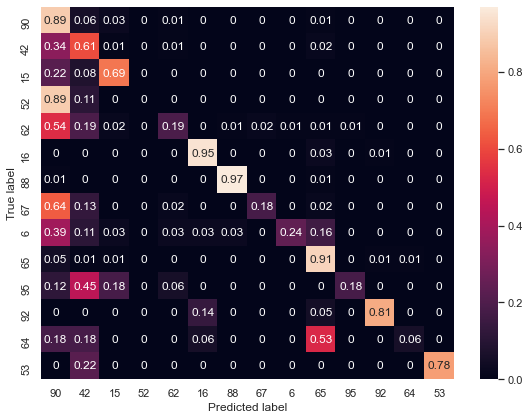

In [134]:
labels = merged_predictions['class'].unique()

y_true = merged_predictions['class']
y_preds = merged_predictions.y_pred

metrics = {}

metrics['global'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_global_confmat.jpg')

## Metrics for ddf objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


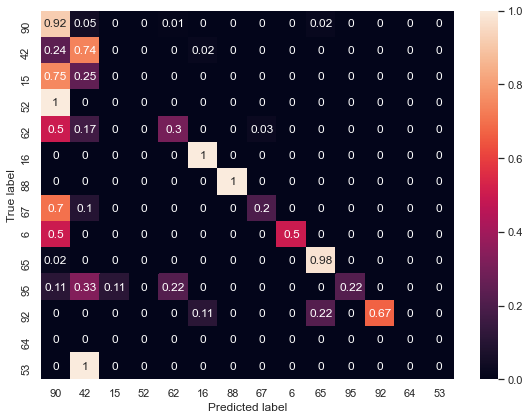

In [135]:
labels = merged_predictions['class'].unique()

ddf_idx = merged_predictions.ddf == True
y_true = merged_predictions[ddf_idx]['class']
y_preds = merged_predictions[ddf_idx].y_pred

metrics['ddf'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_ddf_confmat.jpg')

## Metric for non-ddf objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


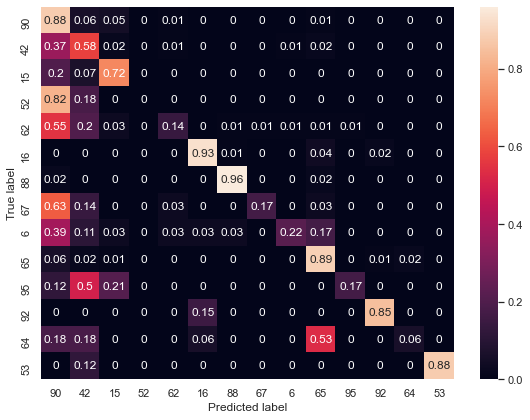

In [136]:
y_true = merged_predictions[~ddf_idx]['class']
y_preds = merged_predictions[~ddf_idx].y_pred

metrics['non-ddf'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_non_ddf_confmat.jpg')

## Metrics for galactic objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


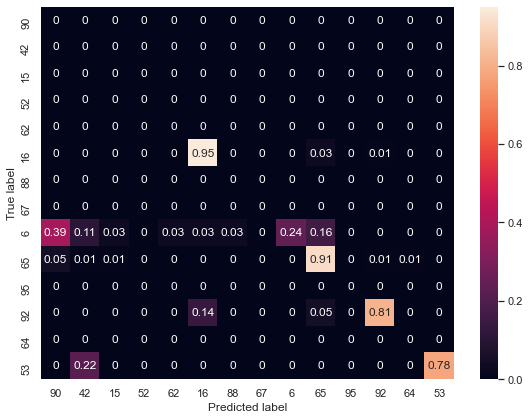

In [137]:
galactic_idx = merged_predictions.galactic == True
y_true = merged_predictions[galactic_idx]['class']
y_preds = merged_predictions[galactic_idx].y_pred

metrics['galactic']=compute_metrics(y_preds, y_true, labels, '../images/plasticc_galactic_confmat.jpg')

## Metrics for non-galactic objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


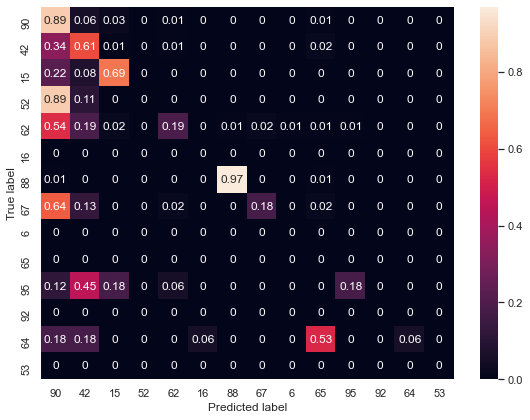

In [138]:
y_true = merged_predictions[~galactic_idx]['class']
y_preds = merged_predictions[~galactic_idx].y_pred

metrics['non-galactic'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_non_galactic_confmat.jpg')

## Metric for both galactic and ddf objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


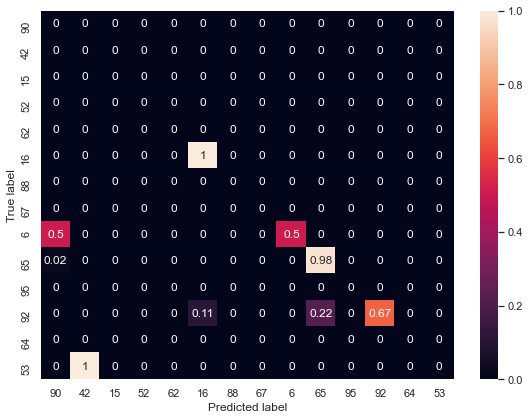

In [139]:
galactic_ddf_idx = (merged_predictions.galactic == True) & (merged_predictions.ddf == True)
y_true = merged_predictions[galactic_ddf_idx]['class']
y_preds = merged_predictions[galactic_ddf_idx].y_pred

metrics['galactic&ddf'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_galactic_ddf_confmat.jpg')

## Metrics for both non-galactic and non-ddf objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


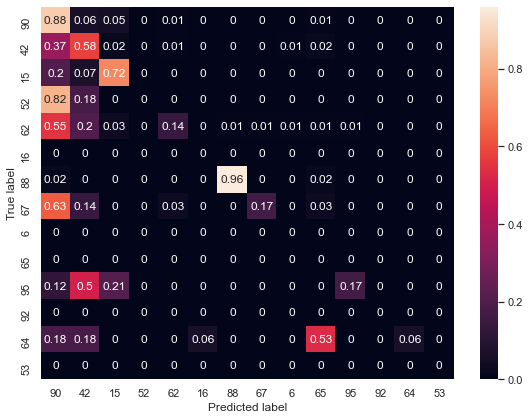

In [144]:
non_galactic_non_ddf_idx = (merged_predictions.galactic == False) & (merged_predictions.ddf == False)
y_true = merged_predictions[non_galactic_non_ddf_idx]['class']
y_preds = merged_predictions[non_galactic_non_ddf_idx].y_pred

metrics['non-galactic&non-ddf'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_non_galactic_non_ddf_confmat.jpg')

## Metrics for both galactic and non-ddf objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


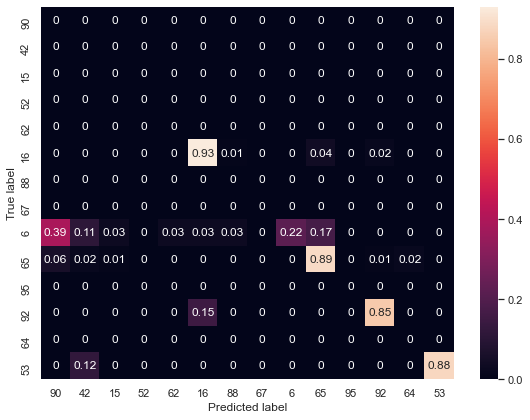

In [141]:
galactic_non_ddf_idx = (merged_predictions.galactic == True) & (merged_predictions.ddf == False)
y_true = merged_predictions[galactic_non_ddf_idx]['class']
y_preds = merged_predictions[galactic_non_ddf_idx].y_pred

metrics['galactic&non-ddf'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_galactic_non_ddf_confmat.jpg')

## Metrics for both non-galactic and ddf objects

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


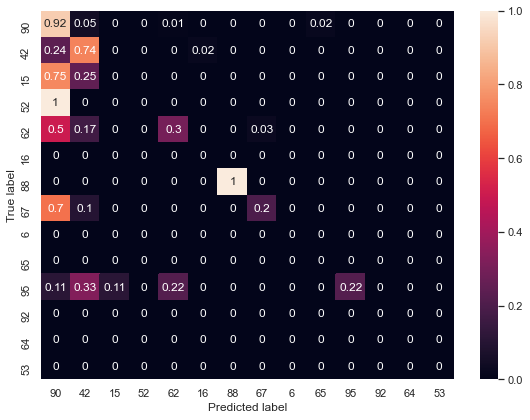

In [143]:
non_galactic_ddf_idx = (merged_predictions.galactic == False) & (merged_predictions.ddf == True)
y_true = merged_predictions[non_galactic_ddf_idx]['class']
y_preds = merged_predictions[non_galactic_ddf_idx].y_pred

metrics['non-galactic&ddf'] = compute_metrics(y_preds, y_true, labels, '../images/plasticc_non_galactic_ddf_confmat.jpg')

In [159]:
galactic_metrics = np.concatenate([
    metrics['galactic&ddf'], 
    metrics['galactic&non-ddf'],
    metrics['galactic']
]).reshape((1, -1))

non_galactic_metrics = np.concatenate([
    metrics['non-galactic&ddf'], 
    metrics['non-galactic&non-ddf'],
    metrics['non-galactic']
]).reshape((1, -1))

ddf_non_dff_metrics = np.concatenate([
    metrics['ddf'],
    metrics['non-ddf'],
    metrics['global']
]).reshape((1, -1))

metric_concat = np.concatenate([galactic_metrics, non_galactic_metrics, ddf_non_dff_metrics], axis=0)

columns = [
    (['ddf']*3)+(['non-ddf']*3)+(['both']*3),
    ['Precision', 'Recall', 'F1 score']*3
]
columns=pd.MultiIndex.from_tuples(list(zip(*columns)))

metrics_df = pd.DataFrame(data=metric_concat, index=['galactic', 'non-galactic', 'both'], columns = columns)
metrics_df

ddf                       non-ddf                      \
             Precision    Recall  F1 score Precision    Recall  F1 score   
galactic      0.959041  0.937500  0.943289  0.937073  0.841398  0.865077   
non-galactic  0.732074  0.747508  0.714338  0.667562  0.642946  0.608364   
both          0.771325  0.793451  0.761156  0.707210  0.705882  0.673398   

                  both                      
             Precision    Recall  F1 score  
galactic      0.943272  0.861111  0.882580  
non-galactic  0.684935  0.671506  0.638047  
both          0.723398  0.728025  0.696127

In [165]:
metrics_df.to_latex('buffer.tex', float_format='%.2f')

# What are the most important features

In [8]:
import sys

sys.path.append('..')

import xgboost as xgb
import joblib
from sast.utils import *
from sast.usast import *

In [17]:
base_folder = '/Users/michael/Downloads/models-m20-M64-l10/'
bands = 'giruyz' # the bands in the same order as during training
usast_g = joblib.load(base_folder + 'u_plassticc_5d_sast_g_cFalse_dTrue_s1_runno2.joblib')
usast_i = joblib.load(base_folder + 'u_plassticc_5d_sast_i_cFalse_dTrue_s1_runno2.joblib')
usast_r = joblib.load(base_folder + 'u_plassticc_5d_sast_r_cFalse_dTrue_s1_runno2.joblib')
usast_u = joblib.load(base_folder + 'u_plassticc_5d_sast_u_cFalse_dTrue_s1_runno2.joblib')
usast_y = joblib.load(base_folder + 'u_plassticc_5d_sast_y_cFalse_dTrue_s1_runno2.joblib')
usast_z = joblib.load(base_folder + 'u_plassticc_5d_sast_z_cFalse_dTrue_s1_runno2.joblib')

/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RidgeClassifierCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/michael/opt/miniconda3/envs/shapeletnet/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [10]:
xgb_clf = joblib.load(base_folder + 'xgb_u_plassticc_5d_cFalse_dTrue_s1_runno2.joblib')
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [11]:
"""
expected_n_features = (usast_g.n_kernels_no_duplicates + 
 usast_i.n_kernels_no_duplicates + 
 usast_r.n_kernels_no_duplicates + 
 usast_u.n_kernels_no_duplicates + 
 usast_y.n_kernels_no_duplicates + 
 usast_z.n_kernels_no_duplicates) * 3 # three because we have [best guesses, counts, uncertainties]

fi = xgb_clf.feature_importances_
n_features = len(fi)

assert n_features == expected_n_features, 'There is problem with the number of features'

m_len = n_features // 3

best_guess_features_indices = [0, m_len - 1]
count_featues_indices = [m_len, 2*m_len - 1]
err_features_indices = [2*m_len, n_features - 1]

print('Best guess features indices: ', best_guess_features_indices)
print('Count features indices: ', count_featues_indices)
print('Uncertainties features indices: ', err_features_indices)
"""

expected_n_features = (usast_g.n_kernels_no_duplicates + 
 usast_i.n_kernels_no_duplicates + 
 usast_r.n_kernels_no_duplicates + 
 usast_u.n_kernels_no_duplicates + 
 usast_y.n_kernels_no_duplicates + 
 usast_z.n_kernels_no_duplicates) * 2 # two because we have [best guesses, uncertainties]

fi = xgb_clf.feature_importances_
n_features = len(fi)

assert n_features == expected_n_features, f'There is problem with the number of features. The classifier has {n_features} and the expected numbers is {expected_n_features}'

m_len = n_features // 2

best_guess_features_indices = [0, m_len - 1]
err_features_indices = [m_len, n_features - 1]

print('Best guess features indices: ', best_guess_features_indices)
print('Uncertainties features indices: ', err_features_indices)

Best guess features indices:  [0, 80251]
Uncertainties features indices:  [80252, 160503]


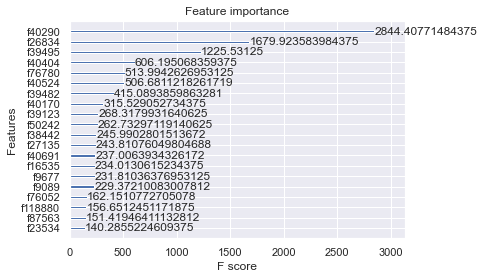

In [12]:
xgb.plot_importance(xgb_clf, max_num_features=20, importance_type='gain');

In [13]:
feature_sorter = np.argsort(xgb_clf.feature_importances_)[::-1]

k = 100 # number of top bests

feature_sorter_topk = feature_sorter[:k]
feature_sorter_topk

array([ 40290,  26834,  39495,  40404,  76780,  40524,  39482,  40170,
        39123,  50242,  38442,  27135,  40691,  16535,   9677,   9089,
        76052, 118880,  87563,  23534,  53848, 141881,  92027, 118891,
        50200,  72478,  40773,  25194,  13796,  90616,  37655,  69698,
        45264,  54690,  65166,  39718,  65853,  19526,  24049,  40360,
        90756,   8014,  73961,   9417, 158600, 103433,    768,  78637,
        27191,  91113, 137892,  65151,  25918,  46543,  60560,  78516,
        14772,  77577, 120900,  26420, 105521,  72236,  12609,  66411,
       128644,  32351,  19362, 139231,  51112, 142806, 105683,  75440,
        36689, 105016,  20734,  39735,  67435, 149543,  64535,   2510,
        71861,  44344,  66472, 109648, 159338,  78876,  35716,  14788,
        50350,  57775,  60811,  76896,  87568,  40388,  22031, 119709,
        20151,  22649,  19811, 114828])

In [14]:
FK_BEST= 'Value'
FK_COUNT = 'Count'
FK_ERR = 'Uncertainty'

def get_kind(idx):
    if idx >= best_guess_features_indices[0] and idx <= best_guess_features_indices[1]:
        return FK_BEST
    if idx >= err_features_indices[0] and idx <= err_features_indices[1]:
        return FK_ERR
    return FK_COUNT

feature_kinds = pd.DataFrame(data=[get_kind(idx) for idx in feature_sorter], index=feature_sorter)
feature_kinds.value_counts()

Value          80252
Uncertainty    80252
dtype: int64

In [15]:
def get_usast_kernel_by_index(index, usast_clf):
    """
    Return the kernel (i.e subsequence) associated to the input `index`
    """
    curr_pos = 0
    kernel = None
    kernel_err = None
    dim_index = 0
    
    for k in usast_clf.kernels_dict.keys():
        n_k = usast_clf.kernels_dict[k].shape[0]
        
        if index < curr_pos + n_k:
            kernel = usast_clf.kernels_dict[k][index-curr_pos]
            kernel_err = usast_clf.kernels_err_dict[k][index-curr_pos]
            break
        else:
            curr_pos += n_k
            dim_index += 1
    
    assert kernel is not None, 'Kernel index out of bound'
    
    return kernel, kernel_err, dim_index

def find_best_match(ts, ts_err, arr, arr_err):
    """Return best match position
    """

    m = len(ts)
    l = len(arr)
    best_dist = np.inf
    best_dist_err = np.inf 
    best_pos = 0

    arr_norm, arr_norm_err = znormalize_uncertain_array(arr, arr_err)

    for i in range(m - l + 1):
        ts_norm, ts_norm_err = znormalize_uncertain_array(ts[i:i+l], ts_err[i:i+l])
        dif = ts_norm - arr_norm
        dist = np.sum(dif**2)
        dist_err = 2 * np.sum(np.abs(dif)*(ts_norm_err+arr_norm_err))

        #We use the simple ordering strategy to compare the uncertain similarities.
        if (dist < best_dist) or ((dist == best_dist) and (dist_err < best_dist_err)):
            best_dist = dist
            best_dist_err = dist_err
            best_pos = i

    return best_pos, best_dist, best_dist_err

def find_best_matching_generator(kernel, kernel_err, usast_clf):
    """
    Find the best matching generator of the kernel
    """
    
    best_match_dist = np.inf
    best_match_dist_err = np.inf
    best_match_class = None
    best_gen = None
    
    for c, gens in usast_clf.kernels_generators_.items():
        
        for i in range(gens.shape[0]):
            gen = gens[i]
            gen_err = usast_clf.kernels_generators_err_[c][i]
            best_pos, best_dist, best_dist_err = find_best_match(gen, gen_err, kernel, kernel_err)
            
            if best_dist < best_match_dist or ((best_dist == best_match_dist) and (best_dist_err < best_match_dist_err)):
                best_match_class = c
                best_match_dist = best_dist
                best_match_dist_err = best_dist_err
                best_gen = (gen, gen_err)
    
    return best_gen, best_match_class, (best_match_dist, best_match_dist_err)
    
def plot_kernel_on_generators(kernel, kernel_err, usast_clf, title=''):
    """
    Plot the input kernel over each reference time series in the classifier and returns the class of the best match
    """
    
    fig = plt.figure(figsize=(16, 16))
    plt.suptitle(title)
    sp_idx = 1
    
    best_match_dist = np.inf
    best_match_dist_err = np.inf
    best_match_class = None
    
    for c, gens in usast_clf.kernels_generators_.items():
        
        for i in range(gens.shape[0]):
            gen = gens[i]
            gen_err = usast_clf.kernels_generators_err_[c][i]
            best_pos, best_dist, best_dist_err = find_best_match(gen, gen_err, kernel, kernel_err)
            
            if best_dist < best_match_dist or ((best_dist == best_match_dist) and (best_dist_err < best_match_dist_err)):
                best_match_class = c
                best_match_dist = best_dist
                best_match_dist_err = best_dist_err

            ax = plt.subplot(7, 2, sp_idx)
            ax.errorbar(np.arange(gen.size), gen, gen_err[:-1], ecolor='red', label=f'Class: {c}')
            ax.errorbar(np.arange(best_pos, best_pos + kernel.size), kernel, kernel_err, ecolor='red', lw=5, c='purple')
            ax.legend()
            
            sp_idx += 1
    
    print('Best match in class', best_match_class, 'with distance', best_match_dist, '+/-', best_match_dist_err)
    
    plt.tight_layout()
    plt.show()
    
    return best_match_class
    
def get_kernel_index_and_clf(idx, kind, models=(usast_g, usast_i, usast_r, usast_u, usast_y, usast_z)):
    """Return the clf from with the kernel came from and the corresponding position in that model's list of kernels
    """
    curr = 0
    pos = -1
    model = None
    
    if kind == FK_ERR:
        idx -= (n_features // 2)
    
    for m in models:
        if idx < m.n_kernels_no_duplicates + curr:
            pos = idx - curr
            model = m
            break
        else:
            curr += m.n_kernels_no_duplicates
            
    assert model is not None, 'Kernel index out of bound'
    
    return pos, model

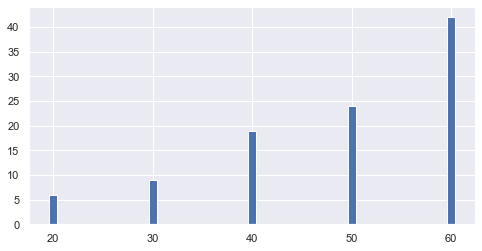

In [18]:
feature_lengths = np.zeros(k)
for i, s in enumerate(feature_sorter_topk):
    pos, model = get_kernel_index_and_clf(s, feature_kinds.loc[s, 0])
    kernel, kernel_err, _ = get_usast_kernel_by_index(pos , model)
    feature_lengths[i] = len(kernel)
    
counts = np.bincount(feature_lengths.astype(int))
barX = np.nonzero(counts)[0]
barH = counts[barX]

plt.figure(figsize=(8, 4))
plt.bar(barX, barH)
plt.xticks(barX)
plt.show()

#### Plot most important features

In [19]:
# sources https://sashamaps.net/docs/resources/20-colors/
color_list = ['#000000', '#800000', '#006400', '#4b0082', '#b8860b', 
              '#000080', '#00ced1', '#ffff00', '#c71585', '#00ff00', 
              '#0000ff', '#ff00ff', '#6495ed', '#ff8c00']
class2color = dict()
for i, c in enumerate(xgb_clf.classes_):
    class2color[c] = color_list[i]
class2color

{6: '#000000',
 15: '#800000',
 16: '#006400',
 42: '#4b0082',
 52: '#b8860b',
 53: '#000080',
 62: '#00ced1',
 64: '#ffff00',
 65: '#c71585',
 67: '#00ff00',
 88: '#0000ff',
 90: '#ff00ff',
 92: '#6495ed',
 95: '#ff8c00'}

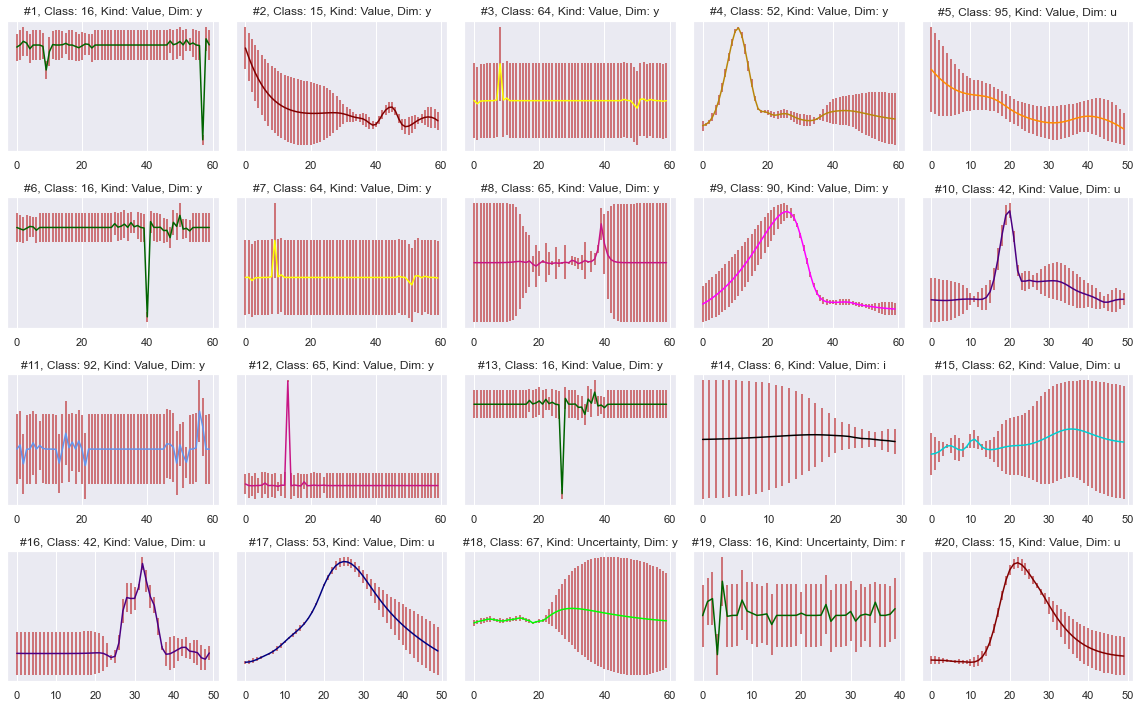

In [29]:
plt.figure(figsize=(16, 10))

for i, index in enumerate(feature_sorter_topk[:20]):
    pos, model = get_kernel_index_and_clf(index, feature_kinds.loc[index, 0])
    kernel, kernel_err, dim_index = get_usast_kernel_by_index(pos , model)
    _, best_match_class, _ = find_best_matching_generator(kernel, kernel_err, model)

    plt.subplot(4, 5, i+1)
    plt.errorbar(x=range(len(kernel)), y=kernel, yerr=kernel_err, ecolor='r', color=class2color[best_match_class])
    plt.title(f'#{i+1}, Class: {best_match_class}, Kind: {feature_kinds.loc[index, 0]}, Dim: {bands[dim_index]}')
    plt.yticks([])
plt.tight_layout()
plt.savefig('../images/top-plasticc-subsequences.png')

#### Plot most important features on generators

Most important feature  0  Kind = Value
Kernel length: 60
Best match in class 16 with distance 0.0 +/- 0.0


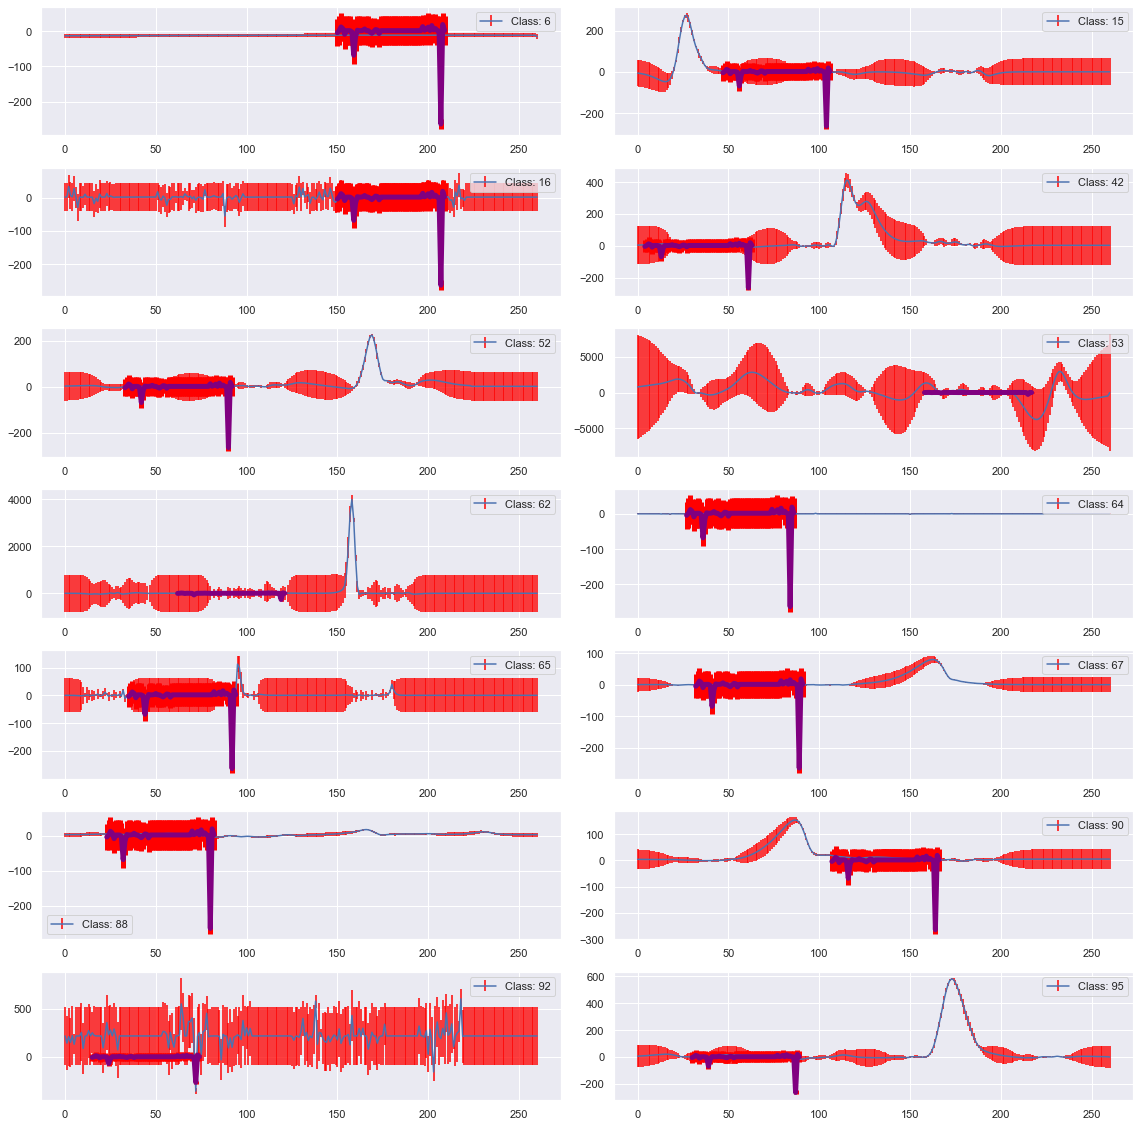

Most important feature  1  Kind = Value
Kernel length: 60
Best match in class 15 with distance 0.0 +/- 0.0


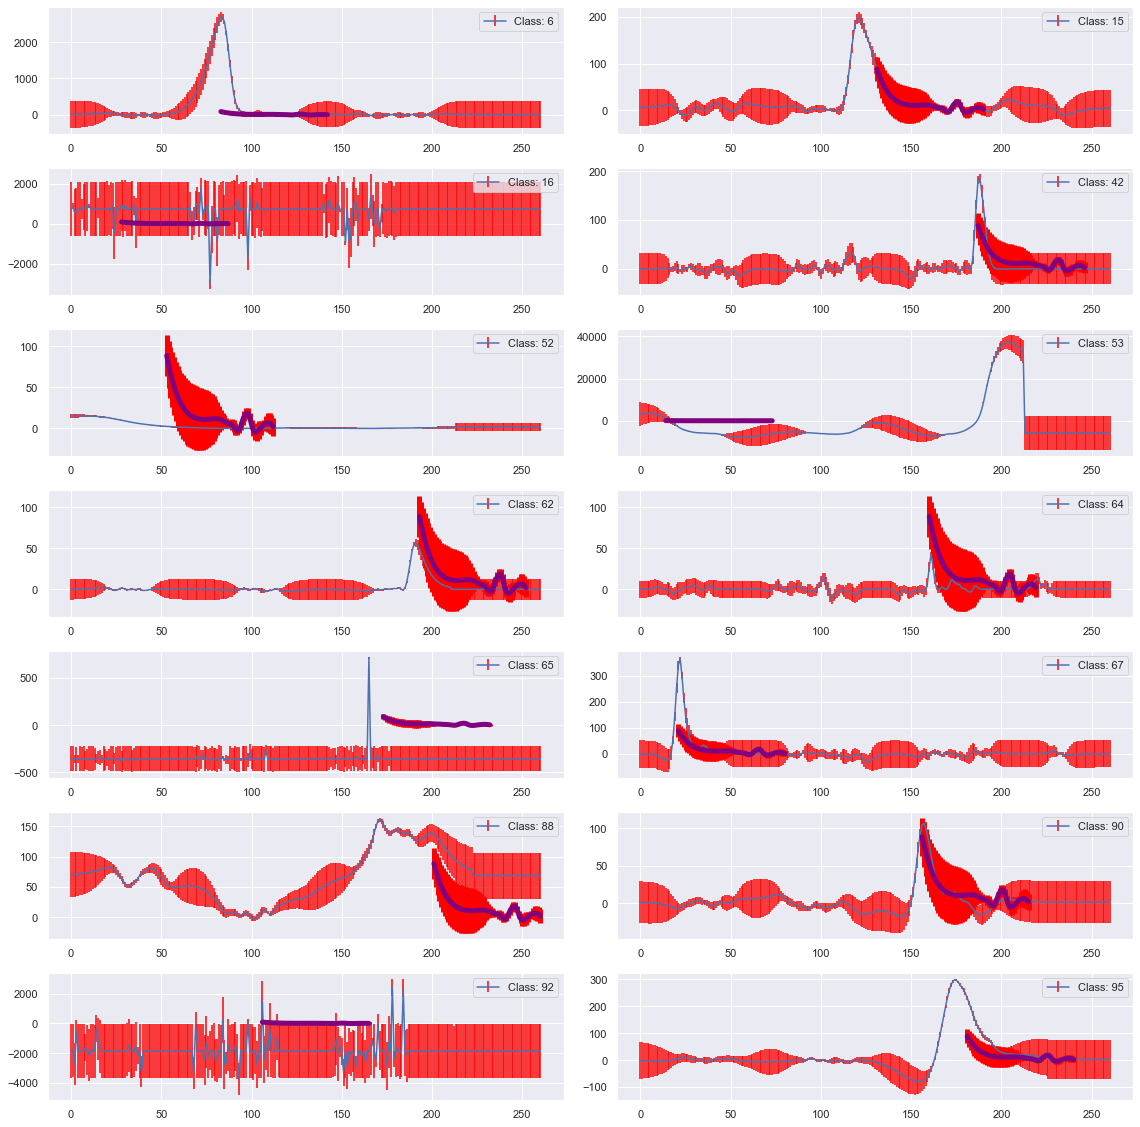

Most important feature  2  Kind = Value
Kernel length: 60
Best match in class 64 with distance 0.0 +/- 0.0


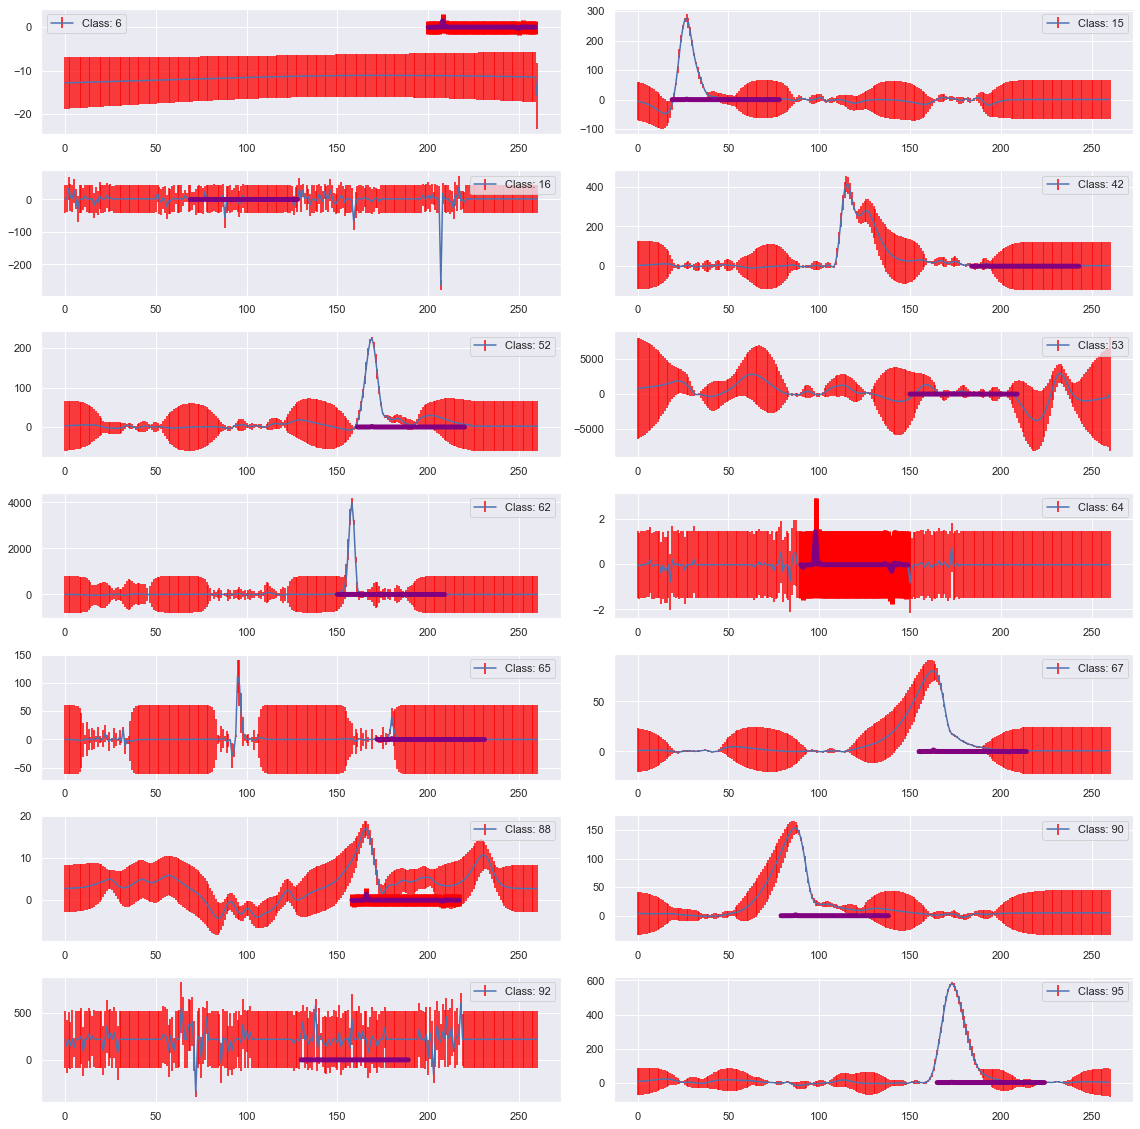

Most important feature  3  Kind = Value
Kernel length: 60
Best match in class 52 with distance 0.0 +/- 0.0


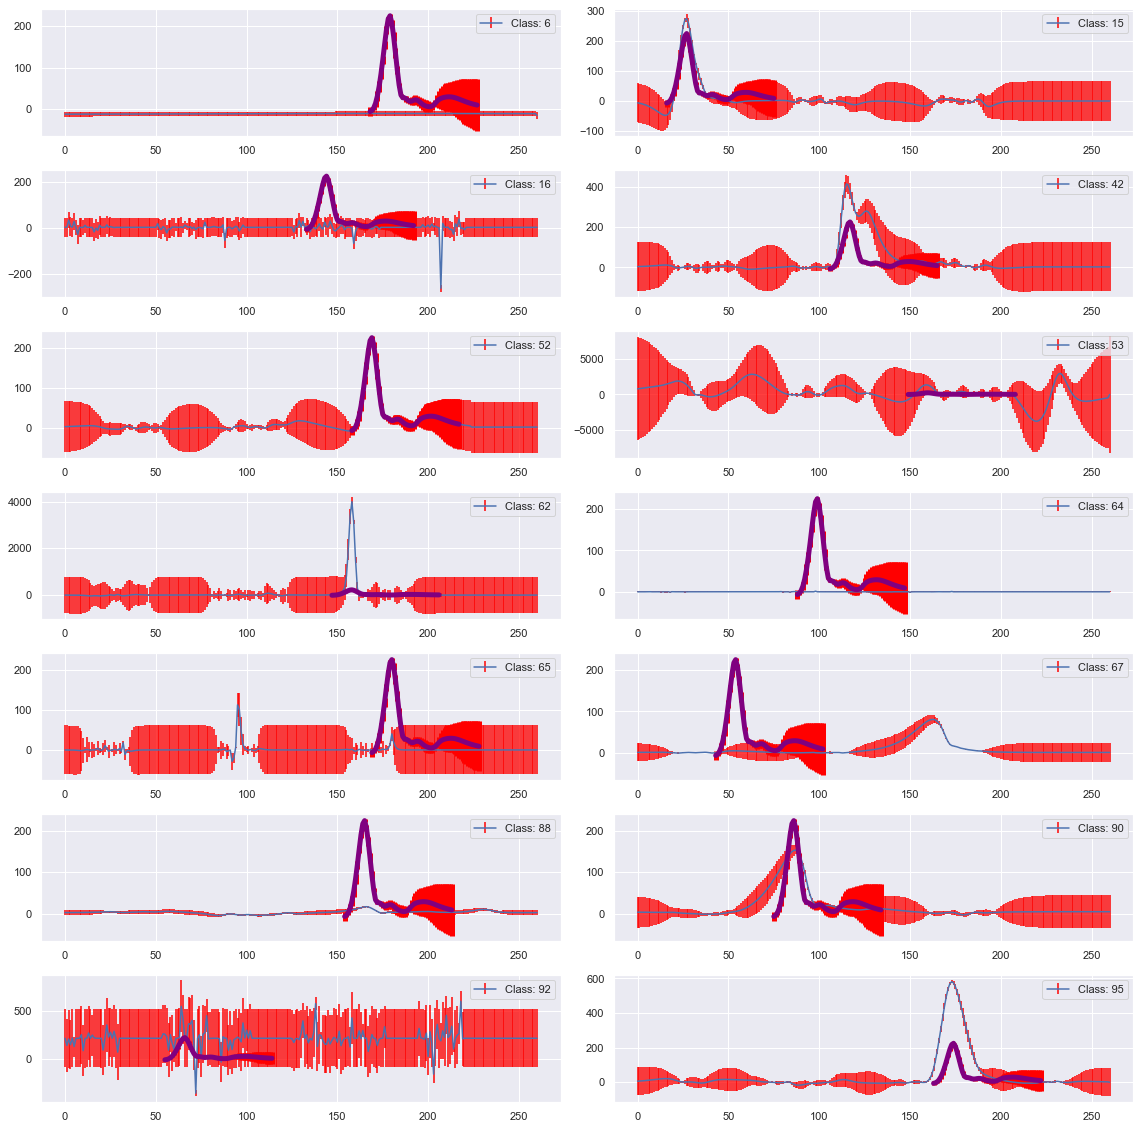

Most important feature  4  Kind = Value
Kernel length: 50
Best match in class 95 with distance 0.0 +/- 0.0


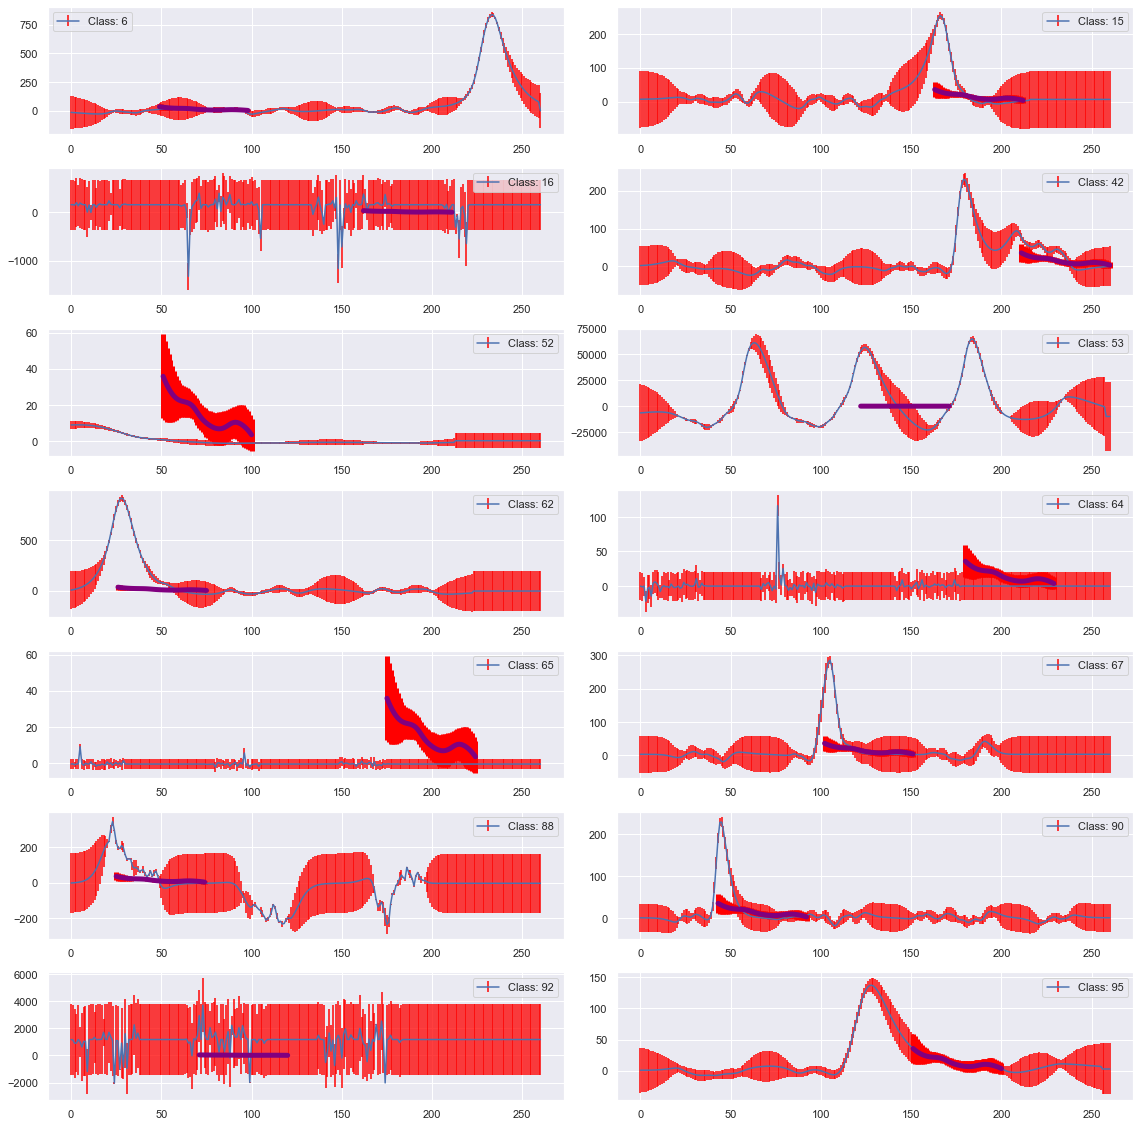

Most important feature  5  Kind = Value
Kernel length: 60
Best match in class 16 with distance 0.0 +/- 0.0


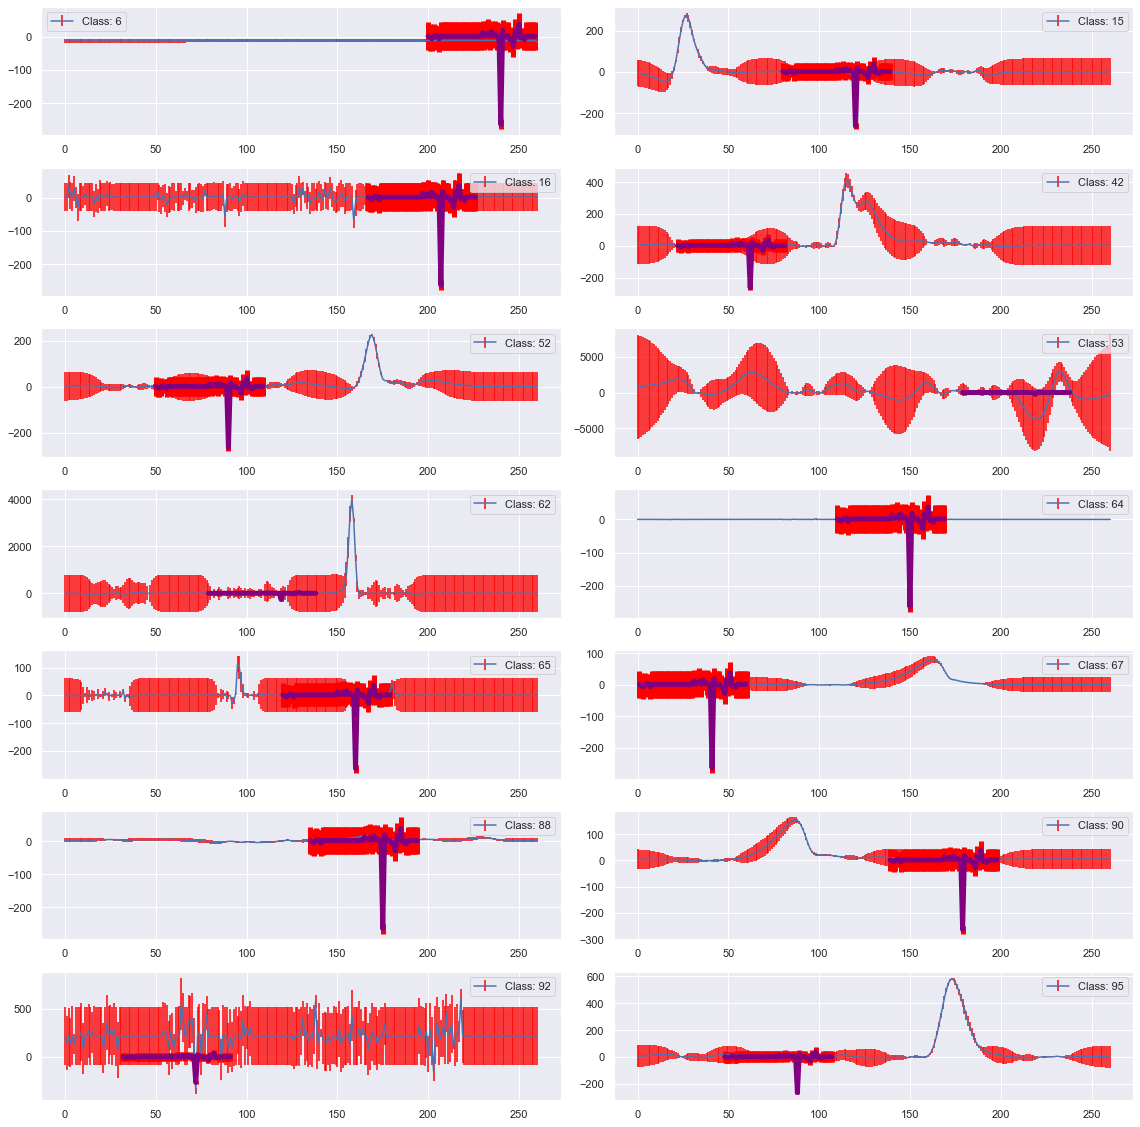

Most important feature  6  Kind = Value
Kernel length: 60
Best match in class 64 with distance 0.0 +/- 0.0


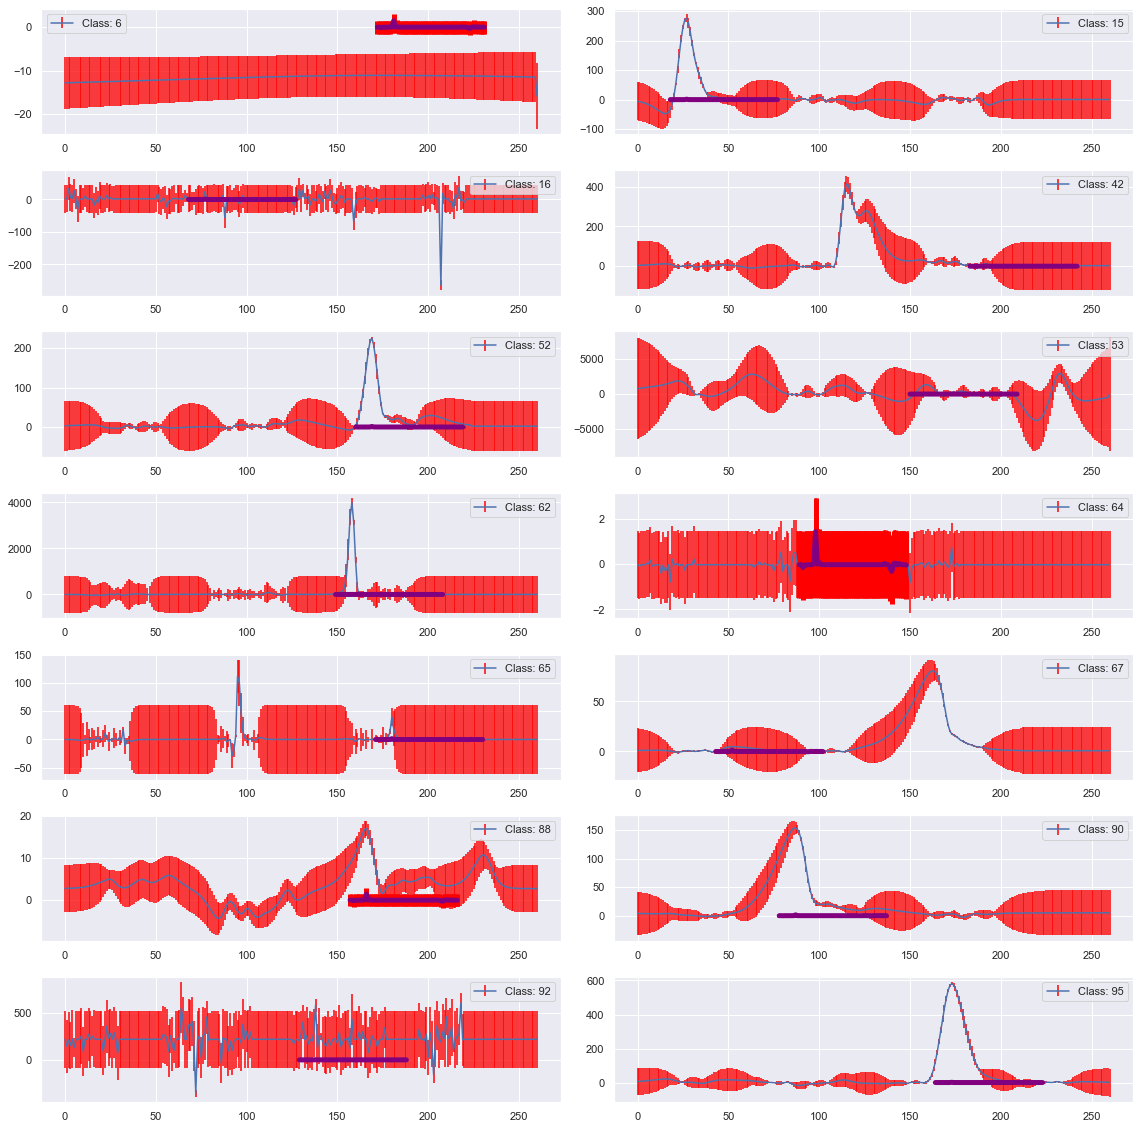

Most important feature  7  Kind = Value
Kernel length: 60
Best match in class 65 with distance 0.0 +/- 0.0


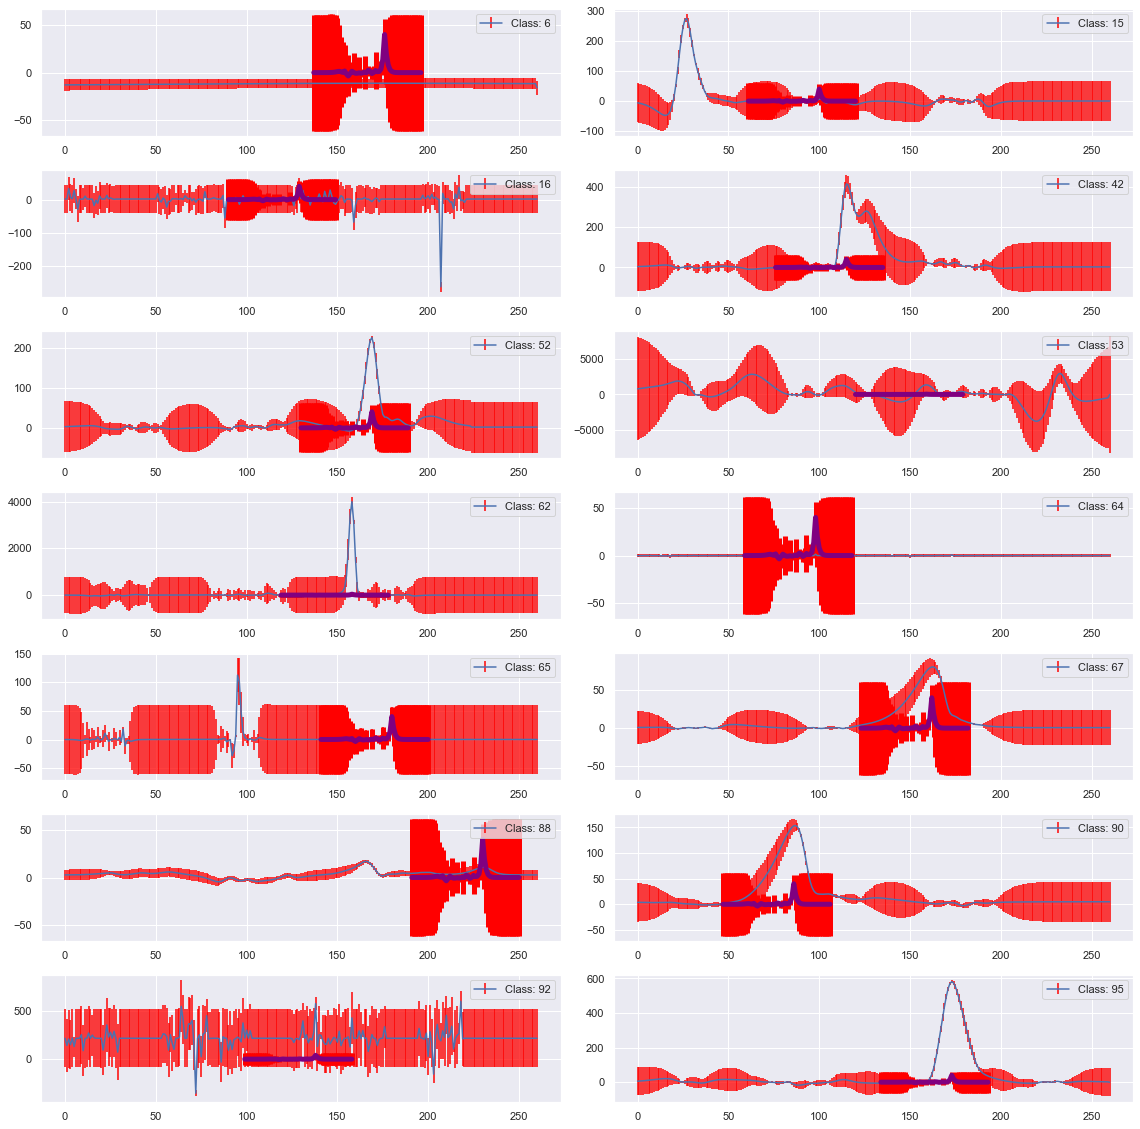

Most important feature  8  Kind = Value
Kernel length: 60
Best match in class 90 with distance 0.0 +/- 0.0


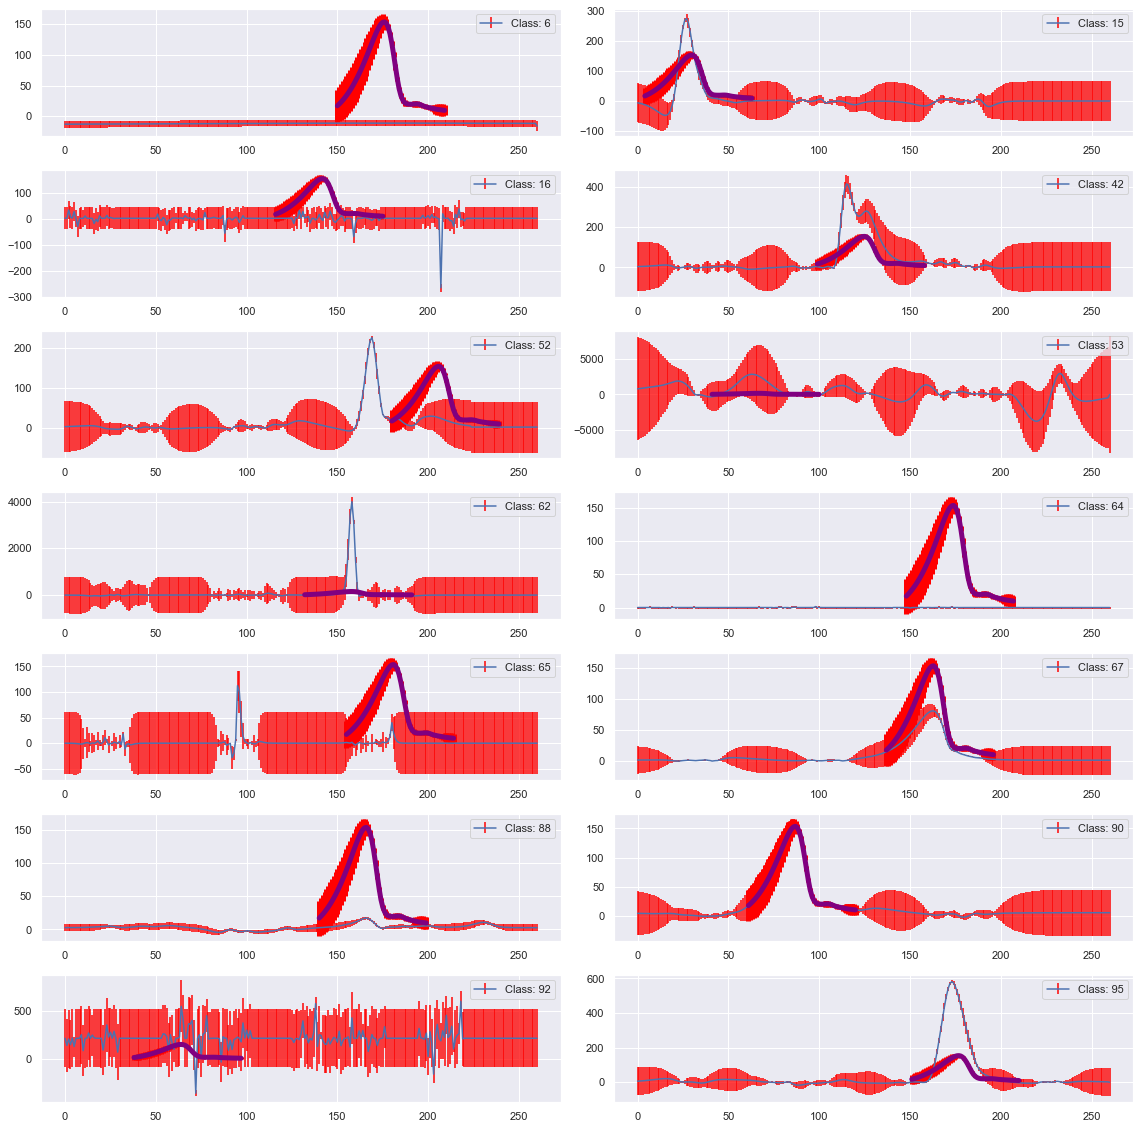

Most important feature  9  Kind = Value
Kernel length: 50
Best match in class 42 with distance 0.0 +/- 0.0


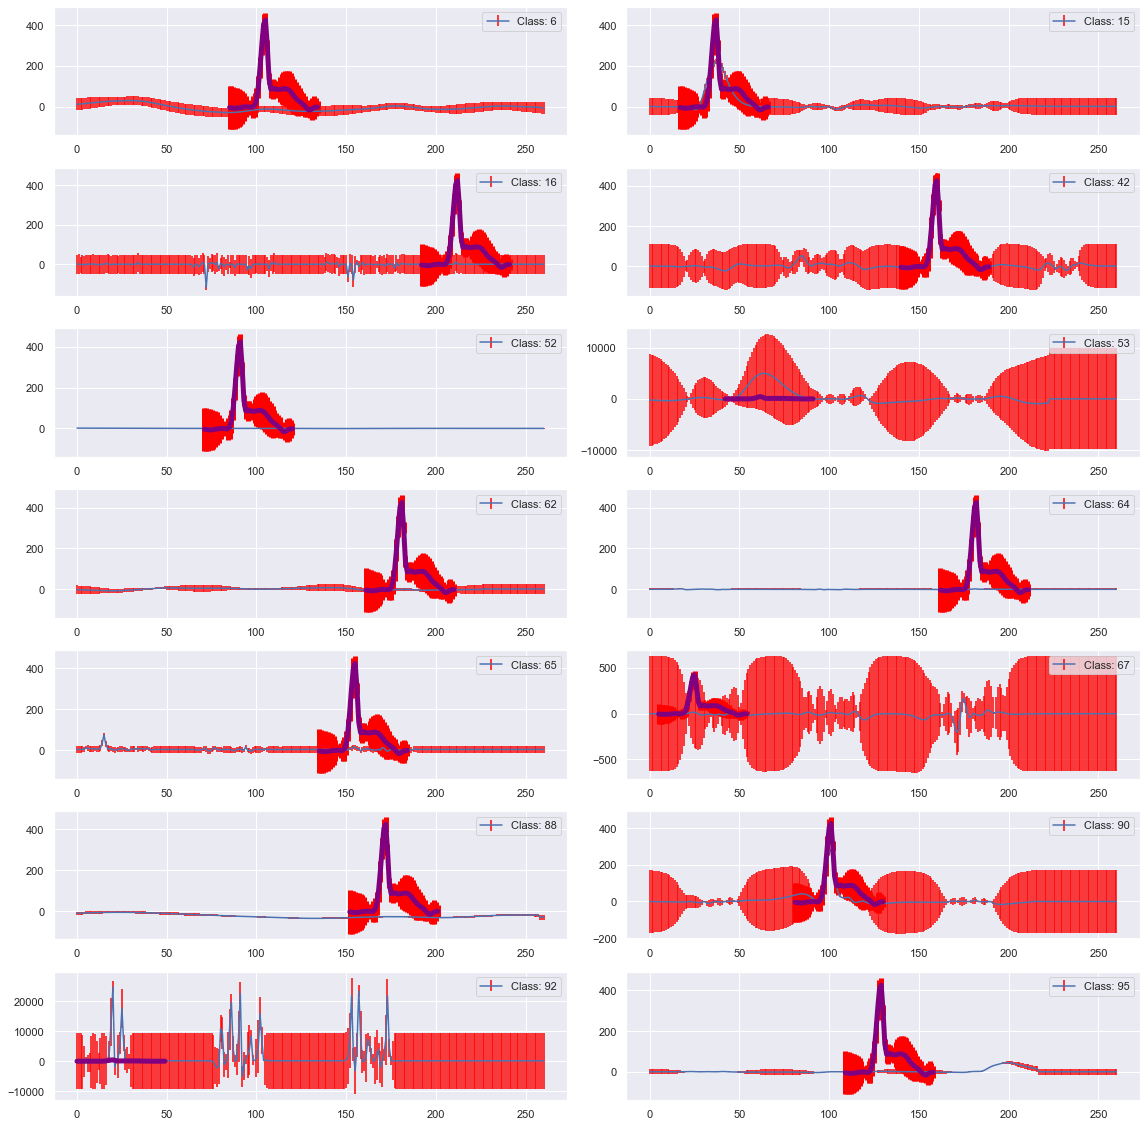

In [142]:
for i, index in enumerate(feature_sorter_topk[:10]):
    print("Most important feature ", i, " Kind =", feature_kinds.loc[index, 0])
    pos, model = get_kernel_index_and_clf(index, feature_kinds.loc[index, 0])
    kernel, kernel_err = get_usast_kernel_by_index(pos , model)
    print('Kernel length:', len(kernel))
    plot_kernel_on_generators(kernel, kernel_err, model)